# Import Dependencies

In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#pip install fredapi 

In [3]:
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import numpy as np
import datetime
import seaborn as sn
from fredapi import Fred 
fred = Fred(api_key='45071d0d8c02d0f45bf4ea219541507f')
plt.rcParams['figure.figsize'] = [12, 8]
currentYear = datetime.datetime.now().year

russell_path = 'Resources/Returns for AJ.xlsx'
inflation_path = 'Resources/inflation_rates.xlsx'
fed_rate_path = 'Resources/fed-funds-rate-historical-chart.csv'
unemployment = fred.get_series('UNRATE', observation_start='1970-1-1')
housing_starts = fred.get_series('HOUST2FNSA', observation_start='1970-1-1') # seasonally ajusted non-fram employment in thousands 
cci_path = 'Resources/cci.csv'
man_emp = fred.get_series('MANEMP', observation_start='1970-1-1') # seasonally ajusted non-fram employment in thousands 

# Create Initial Dataframes

In [4]:
russell_df = pd.read_excel(russell_path, header=1)
inflation_df = pd.read_excel(inflation_path, header=0)
fed_rate_df = pd.read_csv(fed_rate_path)
unemployment_df = unemployment.reset_index().rename(columns = {'index': 'date', 0 :'UNRATE'})
housing_starts_df = housing_starts.reset_index().rename(columns = {'index': 'date', 0 :'Housing Starts'})
cci_df = pd.read_csv(cci_path)
man_emp_df = man_emp.reset_index().rename(columns = {'index': 'date', 0 :'MANEMP'})

In [5]:
# Creat time_period variable for future calculations

time_period = len(russell_df)/12

# Defining Formulas

In [6]:
# Will correct any dates converted incorrectly (> 2022)
def datefix(x):
    if x.year > currentYear:
        year = x.year - 100
    else:
        year = x.year
    return datetime.date(year,x.month,x.day)

#Will Calculate quarter based on month number
def quartercalc(month):
    quarter = 0
    if month in [1,2,3]:
        quarter = 1
    if month in [4,5,6]:
        quarter = 2
    if month in [7,8,9]:
        quarter = 3
    if month in [10,11,12]:
        quarter = 4
    return(quarter)

# Will convert 3 letter month codes to number. (Jan = 1, Dec = 12)
def monthconvert(month):
    datetime_object = datetime.datetime.strptime(month, "%b")
    month_number = datetime_object.month
    return(month_number)

# Will convert percentage values to decimal

def percentageconvert(value):
    return (value / 100)

#Will add one to decimal percentage to allow for compounding. 

def percentagecompound(value):
    return value + 1

#Will subtract one from value created by percentagecompound.

def percentreverse(value):
    return (value-1)

#Will multiply percentage value times 100. 

def hundred(value):
    return(value)*100

#Will determine annualized returns from monthly values. 

def annualfrommonthlyreturns(value):
    return (((value + 1)**12) - 1)

#Will determine annualized returns from monthly values. 

def annualfrommonthlystd(value):
    return value * (12**1/2)

#Will determine annualized returns from monthly values. 

def annualfromquarterlystd(value):
    return value * (4**1/2)


#def highlightTrades(value):
 #   if 'Trade' in value:
  #      return ['background-color: Green']
 
# Swaps favor for portfolio names.     
def portswitch(value):
    if value == 'Russell 1000 Core':
        return 'Core Weighted'
    if value == 'Russell 1000 Growth':
        return 'Growth Weighted'
    if value == 'Russell 1000 Value':
        return 'Value Weighted'

# Data Cleaning

In [7]:
#Creates Month, Day, Year Columns, and converts to numbers. 
unemployment_df['Month'] = unemployment_df['date'].astype(str).str.split('-').str[1]
unemployment_df['Day'] = unemployment_df['date'].astype(str).str.split('-').str[2]
unemployment_df['YEAR'] = unemployment_df['date'].astype(str).str.split('-').str[0]
unemployment_df[['Month', 'YEAR', 'Day']] = unemployment_df[['Month', 'YEAR', 'Day']].apply(pd.to_numeric)

# Adds century to YY
#man_emp_df.loc[man_emp_df['YEAR'] + 2000 > currentYear, "YEAR"] = man_emp_df['YEAR'] + 1900
#man_emp_df.loc[man_emp_df['YEAR'] + 2000 <= currentYear, "YEAR"] = man_emp_df['YEAR'] + 2000

#Calculates Change and Percentage Change
unemployment_df['Unemployment Change'] =  unemployment_df['UNRATE'].shift(-1) - unemployment_df['UNRATE']
unemployment_df['Unemployment Change (Pct)'] = (unemployment_df['Unemployment Change'] / unemployment_df['UNRATE'])*100

#Sets index and removes unwanted columns / rows. 
unemployment_df = unemployment_df.set_index('YEAR')
unemployment_df = unemployment_df.drop(columns = ['date','Day'])
unemployment_df = unemployment_df[(unemployment_df.index > 1978) & (unemployment_df.index < 2016)]

unemployment_df

UNRATE  Month  Unemployment Change  Unemployment Change (Pct)
YEAR                                                               
1979     5.9      1                  0.0                   0.000000
1979     5.9      2                 -0.1                  -1.694915
1979     5.8      3                  0.0                   0.000000
1979     5.8      4                 -0.2                  -3.448276
1979     5.6      5                  0.1                   1.785714
...      ...    ...                  ...                        ...
2015     5.1      8                 -0.1                  -1.960784
2015     5.0      9                  0.0                   0.000000
2015     5.0     10                  0.1                   2.000000
2015     5.1     11                 -0.1                  -1.960784
2015     5.0     12                 -0.2                  -4.000000

[444 rows x 4 columns]

In [8]:
# Parses Date numbers from date, converts them to numbers. 
fed_rate_df['Month'] = fed_rate_df['date'].str.split('/').str[0]
fed_rate_df['Day'] = fed_rate_df['date'].str.split('/').str[1]
fed_rate_df['YEAR'] = fed_rate_df['date'].str.split('/').str[2]
fed_rate_df[['Month', 'YEAR', 'Day']] = fed_rate_df[['Month', 'YEAR', 'Day']].apply(pd.to_numeric)

#converts 'date' to datetime
fed_rate_df['date'] = pd.to_datetime(fed_rate_df['date'])

#adds 1900/2000 to 'YEAR', to update from YY to YYYY, and sets as index
fed_rate_df.loc[fed_rate_df['YEAR'] + 2000 > currentYear, "YEAR"] = fed_rate_df['YEAR'] + 1900
fed_rate_df.loc[fed_rate_df['YEAR'] + 2000 <= currentYear, "YEAR"] = fed_rate_df['YEAR'] + 2000
fed_rate_df = fed_rate_df.set_index('YEAR')

#Applies date fix 
fed_rate_df['date'] = fed_rate_df['date'].apply(datefix)

#fed_rate_df

In [9]:
# Creates list (DF) of values to keep. 

fed_rate_delete = fed_rate_df.copy()
fed_rate_delete = fed_rate_delete.drop([' value'], axis = 1)
fed_rate_delete = fed_rate_delete.groupby(['Month', 'YEAR'], as_index=False, sort = True).max()
fed_rate_delete = fed_rate_delete.drop(columns =['Month','Day'])

#fed_rate_delete

In [10]:
# Finds dates that are in the fed_rate_delete list and created new dataframe
fed_rate_df_clean = fed_rate_df.loc[fed_rate_df['date'].isin(fed_rate_delete['date'])].copy()

# Calculated change and pct change in Fed Rate
fed_rate_df_clean['Fed Rate Change'] =  fed_rate_df_clean[' value'].shift(-1) - fed_rate_df_clean[' value']
fed_rate_df_clean['Fed Rate Change (Pct)'] = (fed_rate_df_clean['Fed Rate Change'] / fed_rate_df_clean[' value'])*100

# Removes years outside of scope, and deletes unwanted columns
fed_rate_df_clean = fed_rate_df_clean[(fed_rate_df_clean.index > 1978) & (fed_rate_df_clean.index < 2016)]
fed_rate_df_clean = fed_rate_df_clean.drop(columns = ['Day'])

# Calculates Quarter from Month
fed_rate_df_clean['Quarter'] = fed_rate_df_clean['Month'].apply(quartercalc)

#fed_rate_df_clean

In [11]:
#Transposes dataset, drops unused columns, and renames remaining. 
inflation_df2 = inflation_df.set_index('YEAR')
inflation_df2 = inflation_df2.drop(columns = 'AVE')
inflation_df2 = inflation_df2.reset_index().melt(id_vars=['YEAR']).set_index(['YEAR'])
inflation_df2 = inflation_df2.rename(columns = {'variable': 'Month', 'value': 'Inflation Rate'})

#inflation_df2.head()

In [12]:
# Converts month codes to numbers. 
inflation_df2['Month'] = inflation_df2.apply(lambda row: monthconvert(row['Month']),axis=1)

#Sorts DF by year and month
inflation_df2 = inflation_df2.sort_values(by=['YEAR', "Month"])

#Calculates change in inflation and percentage change in inflation. 

inflation_df2['Inflation Change'] =  inflation_df2['Inflation Rate'].shift(-1) - inflation_df2['Inflation Rate']
inflation_df2['Inflation Change (Pct)'] = (inflation_df2['Inflation Change'] / inflation_df2['Inflation Rate'])*100

# Removes Years out of scope. 
inflation_df2 = inflation_df2[(inflation_df2.index > 1978) & (inflation_df2.index < 2016)]

#inflation_df2

In [13]:
# Creates Month and Year columns based on Date column, and converts them to numbers. 
russell_df['Month'] = russell_df['Date'].str.split('/').str[0]
russell_df['YEAR'] = russell_df['Date'].str.split('/').str[1]
russell_df[['Month', 'YEAR']] = russell_df[['Month', 'YEAR']].apply(pd.to_numeric)

# Converts YEAR column to YYYY from YY. 
russell_df.loc[russell_df['YEAR'] + 2000 > currentYear, "YEAR"] = russell_df['YEAR'] + 1900
russell_df.loc[russell_df['YEAR'] + 2000 <= currentYear, "YEAR"] = russell_df['YEAR'] + 2000

# Remove Unwanted Columns
russell_df = russell_df.drop(columns = ['Unnamed: 0', 'Date'])

#russell_df.head()

# Begin Merging Dataframes total dataset

In [14]:
# Merge Inflation and Fed Rate Dataframes

market_merge_df = pd.merge(inflation_df2, fed_rate_df_clean, on = ['Month','YEAR'], how = 'left')

#market_merge_df

In [15]:
# Merger market_merge_df with unemployment. 

market_merge_df = pd.merge(market_merge_df,unemployment_df , on = ['Month','YEAR'], how = 'left')
market_merge_df = market_merge_df.reset_index()

#market_merge_df

In [16]:
#Declare column headers, drop unused columns, and reorder columns based on list

column_list = ['date', 'Month', 'Quarter','YEAR','Fed Rate Change', 'Fed Rate Change (Pct)','Unemployment Change','Unemployment Change (Pct)','Inflation Change', 'Inflation Change (Pct)']
market_merge_df = market_merge_df.drop(columns = [' value', 'UNRATE', 'Inflation Rate'])
market_merge_df = market_merge_df.reindex(columns = column_list)

#market_merge_df


In [17]:
# Merger Russell data to market data

market_merge_df = pd.merge(market_merge_df,russell_df , on = ['Month','YEAR'], how = 'left')

#market_merge_df

In [18]:
# Set Index to Year, Quarter, Month, Date

market_merge_df_indexed = market_merge_df.set_index(['YEAR','Quarter','Month','date'])

#market_merge_df_indexed

# Monthly Market Data w/ Indicator Change

In [19]:
# Create Monthly Market Data DF w/ changes (no pct changes)
market_merge_df_no_pct = market_merge_df_indexed.drop(columns = ['Fed Rate Change (Pct)', 'Unemployment Change (Pct)','Inflation Change (Pct)']).copy()
market_merge_df_no_pct = market_merge_df_no_pct[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Fed Rate Change','Unemployment Change','Inflation Change']]

#market_merge_df_no_pct


# Splitting Indicator Dataframe to Create Quarterly / Yearly Dataframes.

In [20]:
# Splitting monthly Indicator data from market dataframe
monthly_indicator_data = market_merge_df_no_pct[['Fed Rate Change', 'Unemployment Change','Inflation Change']].reset_index().groupby(['YEAR','Quarter','Month']).agg({'date':'max','Fed Rate Change': 'sum','Unemployment Change': 'sum','Inflation Change': 'sum'}).reset_index().set_index(['YEAR', 'Quarter','Month', 'date'])

#monthly_indicator_data


# Quarterly

In [21]:
# Aggregating indicator data quarterly
quarterly_indicator_data = market_merge_df_no_pct[['Fed Rate Change', 'Unemployment Change','Inflation Change']].reset_index().drop(columns = 'Month').groupby(['YEAR','Quarter']).agg({'date':'max','Fed Rate Change': 'sum','Unemployment Change': 'sum','Inflation Change': 'sum'}).reset_index().set_index(['YEAR', 'Quarter', 'date'])

#quarterly_indicator_data

# Yearly

In [22]:
# Aggregating indicator data, yearly. 

yearly_indicator_data = market_merge_df_no_pct[['Fed Rate Change', 'Unemployment Change','Inflation Change']].reset_index().drop(columns = ['Month','Quarter']).groupby(['YEAR']).agg({'date':'max','Fed Rate Change': 'sum','Unemployment Change': 'sum','Inflation Change': 'sum'}).reset_index().set_index(['YEAR', 'date'])

#yearly_indicator_data

# # Monthly Market Data w/ Indicator Change (Pct)

In [23]:
# Creating monthly dataframe with pct changes
market_merge_pct_monthly = market_merge_df_indexed.drop(columns = ['Fed Rate Change', 'Unemployment Change','Inflation Change']).reindex(columns = ['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Fed Rate Change (Pct)','Unemployment Change (Pct)','Inflation Change (Pct)']).copy()

#market_merge_pct_monthly

# Monthly Market Data For Compounding

# Splitting Compounding Dataframe to Create Quarterly / Yearly Dataframes. 

In [24]:
#Removing non percentage columns from dataframe to create compounding dataframe (/100 + 1 to returns and pct changes)
market_merge_df_compound = market_merge_df_indexed.drop(columns = ['Fed Rate Change', 'Unemployment Change','Inflation Change']).copy()
market_merge_df_compound = market_merge_df_compound[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Fed Rate Change (Pct)','Unemployment Change (Pct)','Inflation Change (Pct)']].apply(percentageconvert).apply(percentagecompound)
market_merge_df_compound = market_merge_df_compound.replace([np.inf, -np.inf],1)

market_merge_df_compound


Russell 1000 Core  Russell 1000 Growth  \
YEAR Quarter Month date                                                 
1979 1       1     1979-01-31           1.044800             1.034620   
             2     1979-02-28           0.972435             0.966039   
             3     1979-03-31           1.062500             1.065243   
     2       4     1979-04-30           1.005465             1.006406   
             5     1979-05-31           0.986364             0.983894   
...                                          ...                  ...   
2015 3       8     2015-08-31           0.939847             0.939271   
             9     2015-09-30           0.972592             0.975262   
     4       10    2015-10-31           1.080909             1.086106   
             11    2015-11-30           1.003303             1.002807   
             12    2015-12-31           0.982010             0.985325   

                               Russell 1000 Value  Fed Rate Change (Pct)  \
YEAR Quarter Month date                                                    
1979 1       1     1979-01-31            1.055028               0.968780   
             2     1979-02-28            0.978610               0.983398   
             3     1979-03-31            1.059631               1.035750   
     2       4     1979-04-30            1.004707               0.988495   
             5     1979-05-31            0.988682               1.022308   
...                                           ...                    ...   
2015 3       8     2015-08-31            0.940443               0.875000   
             9     2015-09-30            0.969810               1.000000   
     4       10    2015-10-31            1.075453               1.142857   
             11    2015-11-30            1.003827               2.500000   
             12    2015-12-31            0.978494               1.450000   

                               Unemployment Change (Pct)  \
YEAR Quarter Month date                                    
1979 1       1     1979-01-31                   1.000000   
             2     1979-02-28                   0.983051   
             3     1979-03-31                   1.000000   
     2       4     1979-04-30                   0.965517   
             5     1979-05-31                   1.017857   
...                                                  ...   
2015 3       8     2015-08-31                   0.980392   
             9     2015-09-30                   1.000000   
     4       10    2015-10-31                   1.020000   
             11    2015-11-30                   0.980392   
             12    2015-12-31                   0.960000   

                               Inflation Change (Pct)  
YEAR Quarter Month date                                
1979 1       1     1979-01-31                1.064516  
             2     1979-02-28                1.020202  
             3     1979-03-31                1.039604  
     2       4     1979-04-30                1.038095  
             5     1979-05-31                1.000000  
...                                               ...  
2015 3       8     2015-08-31                0.000000  
             9     2015-09-30                1.000000  
     4       10    2015-10-31                2.500000  
             11    2015-11-30                1.400000  
             12    2015-12-31                2.000000  

[444 rows x 6 columns]

## Quarterly

In [25]:
# Aggregating russell pct dataframe quarterly
quarterly_strat_data = market_merge_df_compound[['Russell 1000 Core', 'Russell 1000 Growth','Russell 1000 Value']].reset_index().drop(columns = 'Month').groupby(['YEAR','Quarter']).agg({'date':'max','Russell 1000 Core': 'prod','Russell 1000 Growth': 'prod','Russell 1000 Value': 'prod'}).reset_index().set_index(['YEAR', 'Quarter', 'date']).apply(percentreverse)

#quarterly_strat_data

## Yearly

In [26]:
# Aggregating russell pct dataframe yearly

yearly_strat_data = market_merge_df_compound[['Russell 1000 Core', 'Russell 1000 Growth','Russell 1000 Value']].reset_index().drop(columns = ['Month', 'Quarter']).groupby(['YEAR']).agg({'date':'max','Russell 1000 Core': 'prod','Russell 1000 Growth': 'prod','Russell 1000 Value': 'prod'}).reset_index().set_index(['YEAR','date']).apply(percentreverse).round(6)

#yearly_strat_data


# Completed Data Frames

# Simple

### Monthly

In [27]:
# Simple, monthly indicator changes + russell returns. 

monthly_indicator_join = monthly_indicator_data.reset_index().drop(columns = ['YEAR', 'Quarter','Month'])
monthly_strat_join = market_merge_df_compound.reset_index().drop(columns = ['YEAR','Quarter','Month','Fed Rate Change (Pct)','Unemployment Change (Pct)', 'Inflation Change (Pct)']).set_index('date').apply(percentreverse)
simple_monthly_md = pd.merge(monthly_strat_join,monthly_indicator_join, how = 'left', on = 'date').set_index('date')

simple_monthly_md


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-01-31           0.044800             0.034620            0.055028   
1979-02-28          -0.027565            -0.033961           -0.021390   
1979-03-31           0.062500             0.065243            0.059631   
1979-04-30           0.005465             0.006406            0.004707   
1979-05-31          -0.013636            -0.016106           -0.011318   
...                       ...                  ...                 ...   
2015-08-31          -0.060153            -0.060729           -0.059557   
2015-09-30          -0.027408            -0.024738           -0.030190   
2015-10-31           0.080909             0.086106            0.075453   
2015-11-30           0.003303             0.002807            0.003827   
2015-12-31          -0.017990            -0.014675           -0.021506   

            Fed Rate Change  Unemployment Change  Inflation Change  
date                                                                
1979-01-31            -0.33                  0.0               0.6  
1979-02-28            -0.17                 -0.1               0.2  
1979-03-31             0.36                  0.0               0.4  
1979-04-30            -0.12                 -0.2               0.4  
1979-05-31             0.23                  0.1               0.0  
...                     ...                  ...               ...  
2015-08-31            -0.01                 -0.1              -0.2  
2015-09-30             0.00                  0.0               0.2  
2015-10-31             0.01                  0.1               0.3  
2015-11-30             0.12                 -0.1               0.2  
2015-12-31             0.09                 -0.2               0.7  

[444 rows x 6 columns]

## Quarterly

In [28]:
# Simple, quarterly indicator changes + russell returns. 

quarterly_indicator_join = quarterly_indicator_data.reset_index().drop(columns = ['YEAR', 'Quarter'])
quarterly_strat_join = quarterly_strat_data.reset_index().drop(columns = ['YEAR', 'Quarter'])
simple_quarterly_md = pd.merge(quarterly_strat_join,quarterly_indicator_join, how = 'left', on = 'date').set_index('date')

simple_quarterly_md


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            Fed Rate Change  Unemployment Change  Inflation Change  
date                                                                
1979-03-31            -0.14                 -0.1               1.2  
1979-06-30             0.38                 -0.1               0.8  
1979-09-30             4.01                  0.3               0.8  
1979-12-31            -1.42                  0.3               1.8  
1980-03-31             1.24                  0.6               0.8  
...                     ...                  ...               ...  
2014-12-31            -0.01                  0.0              -1.8  
2015-03-31             0.02                 -0.3              -0.1  
2015-06-30             0.00                 -0.2               0.4  
2015-09-30            -0.01                 -0.2               0.0  
2015-12-31             0.22                 -0.2               1.2  

[148 rows x 6 columns]

## Yearly

In [29]:
# Simple, yearly indicator changes + russell returns. 

yearly_indicator_join = yearly_indicator_data.reset_index().drop(columns = ['YEAR'])
yearly_strat_join = yearly_strat_data.reset_index().drop(columns = ['YEAR'])
simple_yearly_md = pd.merge(yearly_strat_join,yearly_indicator_join, how = 'left', on = 'date').set_index('date')

simple_yearly_md

Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-12-31           0.223300             0.239033            0.205474   
1980-12-31           0.318728             0.395721            0.244132   
1981-12-31          -0.051017            -0.113093            0.012578   
1982-12-31           0.203083             0.204562            0.200381   
1983-12-31           0.221251             0.159838            0.282853   
1984-12-31           0.047526            -0.009525            0.100977   
1985-12-31           0.322638             0.328545            0.315152   
1986-12-31           0.178700             0.153619            0.199798   
1987-12-31           0.029265             0.053055            0.004985   
1988-12-31           0.172556             0.112666            0.231601   
1989-12-31           0.304295             0.359236            0.251902   
1990-12-31          -0.042095            -0.002593           -0.080832   
1991-12-31           0.330378             0.412700            0.245500   
1992-12-31           0.089310             0.049904            0.135849   
1993-12-31           0.101772             0.028722            0.180674   
1994-12-31           0.003890             0.026216           -0.019757   
1995-12-31           0.377670             0.371754            0.383560   
1996-12-31           0.224471             0.231225            0.216417   
1997-12-31           0.328517             0.304890            0.351840   
1998-12-31           0.270234             0.387067            0.156290   
1999-12-31           0.209119             0.331580            0.073477   
2000-12-31          -0.077891            -0.224239            0.070147   
2001-12-31          -0.124496            -0.204233           -0.055896   
2002-12-31          -0.216526            -0.278841           -0.155232   
2003-12-31           0.298908             0.297491            0.300305   
2004-12-31           0.114046             0.063000            0.164937   
2005-12-31           0.062657             0.052631            0.070538   
2006-12-31           0.154609             0.090737            0.222455   
2007-12-31           0.057741             0.118129           -0.001733   
2008-12-31          -0.375966            -0.384372           -0.368483   
2009-12-31           0.284326             0.372088            0.196903   
2010-12-31           0.160970             0.167106            0.155060   
2011-12-31           0.015007             0.026420            0.003905   
2012-12-31           0.164223             0.152578            0.175088   
2013-12-31           0.331112             0.334849            0.325268   
2014-12-31           0.132385             0.130498            0.134525   
2015-12-31           0.009175             0.056673           -0.038273   

            Fed Rate Change  Unemployment Change  Inflation Change  
date                                                                
1979-12-31             2.83                  0.4               4.6  
1980-12-31             3.85                  1.2              -2.1  
1981-12-31            -3.04                  1.1              -3.4  
1982-12-31            -5.65                  1.8              -4.7  
1983-12-31             0.79                 -2.4               0.5  
1984-12-31            -0.62                 -0.7              -0.7  
1985-12-31            -0.64                 -0.6               0.4  
1986-12-31            -1.81                 -0.1              -2.4  
1987-12-31             0.51                 -0.9               2.5  
1988-12-31             2.35                 -0.3               0.7  
1989-12-31            -0.88                  0.0               0.5  
1990-12-31            -0.08                  1.0               0.5  
1991-12-31            -3.78                  0.9              -3.1  
1992-12-31            -1.38                  0.0               0.7  
1993-12-31           

## Relative

### Monthly - Relative

In [30]:
# Relative, Monthly indicator changes + russell returns. 

relative_monthly_md = market_merge_df_compound.reset_index().drop(columns = ['YEAR','Quarter','Month']).set_index('date').apply(percentreverse)

relative_monthly_md


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-01-31           0.044800             0.034620            0.055028   
1979-02-28          -0.027565            -0.033961           -0.021390   
1979-03-31           0.062500             0.065243            0.059631   
1979-04-30           0.005465             0.006406            0.004707   
1979-05-31          -0.013636            -0.016106           -0.011318   
...                       ...                  ...                 ...   
2015-08-31          -0.060153            -0.060729           -0.059557   
2015-09-30          -0.027408            -0.024738           -0.030190   
2015-10-31           0.080909             0.086106            0.075453   
2015-11-30           0.003303             0.002807            0.003827   
2015-12-31          -0.017990            -0.014675           -0.021506   

            Fed Rate Change (Pct)  Unemployment Change (Pct)  \
date                                                           
1979-01-31              -0.031220                   0.000000   
1979-02-28              -0.016602                  -0.016949   
1979-03-31               0.035750                   0.000000   
1979-04-30              -0.011505                  -0.034483   
1979-05-31               0.022308                   0.017857   
...                           ...                        ...   
2015-08-31              -0.125000                  -0.019608   
2015-09-30               0.000000                   0.000000   
2015-10-31               0.142857                   0.020000   
2015-11-30               1.500000                  -0.019608   
2015-12-31               0.450000                  -0.040000   

            Inflation Change (Pct)  
date                                
1979-01-31                0.064516  
1979-02-28                0.020202  
1979-03-31                0.039604  
1979-04-30                0.038095  
1979-05-31                0.000000  
...                            ...  
2015-08-31               -1.000000  
2015-09-30                0.000000  
2015-10-31                1.500000  
2015-11-30                0.400000  
2015-12-31                1.000000  

[444 rows x 6 columns]

## Quarterly - Relative

In [31]:
# Relative, Quarterly indicator changes + russell returns. 

relative_quarterly_md = market_merge_df_compound.reset_index().drop(columns = ['Month']).groupby(['YEAR','Quarter']).agg({'date':'max','Russell 1000 Core': 'prod','Russell 1000 Growth': 'prod','Russell 1000 Value': 'prod','Fed Rate Change (Pct)': 'prod','Unemployment Change (Pct)': 'prod','Inflation Change (Pct)': 'prod'}).reset_index().drop(columns = ['YEAR', 'Quarter']).set_index('date').apply(percentreverse).round(4)

relative_quarterly_md

Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31             0.0795               0.0647              0.0940   
1979-06-30             0.0374               0.0284              0.0464   
1979-09-30             0.0809               0.0823              0.0796   
1979-12-31             0.0106               0.0456             -0.0247   
1980-03-31            -0.0566              -0.0527             -0.0602   
...                       ...                  ...                 ...   
2014-12-31             0.0488               0.0478              0.0498   
2015-03-31             0.0159               0.0384             -0.0072   
2015-06-30             0.0011               0.0012              0.0011   
2015-09-30            -0.0683              -0.0529             -0.0839   
2015-12-31             0.0650               0.0732              0.0564   

            Fed Rate Change (Pct)  Unemployment Change (Pct)  \
date                                                           
1979-03-31                -0.0132                    -0.0169   
1979-06-30                 0.0364                    -0.0172   
1979-09-30                 0.3710                     0.0526   
1979-12-31                -0.0958                     0.0500   
1980-03-31                 0.0925                     0.0952   
...                           ...                        ...   
2014-12-31                -0.1429                    -0.0000   
2015-03-31                 0.3333                    -0.0526   
2015-06-30                 0.0000                    -0.0370   
2015-09-30                -0.1250                    -0.0385   
2015-12-31                 3.1429                    -0.0400   

            Inflation Change (Pct)  
date                                
1979-03-31                  0.1290  
1979-06-30                  0.0762  
1979-09-30                  0.0708  
1979-12-31                  0.1488  
1980-03-31                  0.0576  
...                            ...  
2014-12-31                 -1.0588  
2015-03-31                 -1.0000  
2015-06-30                 -1.0000  
2015-09-30                 -1.0000  
2015-12-31                  6.0000  

[148 rows x 6 columns]

## Yearly - Relative


In [32]:
# Relative, Yearly indicator changes + russell returns. 

relative_yearly_md = market_merge_df_compound.reset_index().drop(columns = ['Month','Quarter']).groupby(['YEAR']).agg({'date':'max','Russell 1000 Core': 'prod','Russell 1000 Growth': 'prod','Russell 1000 Value': 'prod','Fed Rate Change (Pct)': 'prod','Unemployment Change (Pct)': 'prod','Inflation Change (Pct)': 'prod'}).reset_index().drop(columns = ['YEAR']).set_index('date').apply(percentreverse).round(6)

relative_yearly_md


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-12-31           0.223300             0.239033            0.205474   
1980-12-31           0.318728             0.395721            0.244132   
1981-12-31          -0.051017            -0.113093            0.012578   
1982-12-31           0.203083             0.204562            0.200381   
1983-12-31           0.221251             0.159838            0.282853   
1984-12-31           0.047526            -0.009525            0.100977   
1985-12-31           0.322638             0.328545            0.315152   
1986-12-31           0.178700             0.153619            0.199798   
1987-12-31           0.029265             0.053055            0.004985   
1988-12-31           0.172556             0.112666            0.231601   
1989-12-31           0.304295             0.359236            0.251902   
1990-12-31          -0.042095            -0.002593           -0.080832   
1991-12-31           0.330378             0.412700            0.245500   
1992-12-31           0.089310             0.049904            0.135849   
1993-12-31           0.101772             0.028722            0.180674   
1994-12-31           0.003890             0.026216           -0.019757   
1995-12-31           0.377670             0.371754            0.383560   
1996-12-31           0.224471             0.231225            0.216417   
1997-12-31           0.328517             0.304890            0.351840   
1998-12-31           0.270234             0.387067            0.156290   
1999-12-31           0.209119             0.331580            0.073477   
2000-12-31          -0.077891            -0.224239            0.070147   
2001-12-31          -0.124496            -0.204233           -0.055896   
2002-12-31          -0.216526            -0.278841           -0.155232   
2003-12-31           0.298908             0.297491            0.300305   
2004-12-31           0.114046             0.063000            0.164937   
2005-12-31           0.062657             0.052631            0.070538   
2006-12-31           0.154609             0.090737            0.222455   
2007-12-31           0.057741             0.118129           -0.001733   
2008-12-31          -0.375966            -0.384372           -0.368483   
2009-12-31           0.284326             0.372088            0.196903   
2010-12-31           0.160970             0.167106            0.155060   
2011-12-31           0.015007             0.026420            0.003905   
2012-12-31           0.164223             0.152578            0.175088   
2013-12-31           0.331112             0.334849            0.325268   
2014-12-31           0.132385             0.130498            0.134525   
2015-12-31           0.009175             0.056673           -0.038273   

            Fed Rate Change (Pct)  Unemployment Change (Pct)  \
date                                                           
1979-12-31               0.267739                   0.067797   
1980-12-31               0.287313                   0.190476   
1981-12-31              -0.176232                   0.146667   
1982-12-31              -0.397607                   0.209302   
1983-12-31               0.092290                  -0.230769   
1984-12-31              -0.066310                  -0.087500   
1985-12-31              -0.073310                  -0.082192   
1986-12-31              -0.223733                  -0.014925   
1987-12-31               0.081210                  -0.136364   
1988-12-31               0.346097                  -0.052632   
1989-12-31              -0.096280                   0.000000   
1990-12-31              -0.009685                   0.185185   
1991-12-31              -0.462103                   0.140625   
1992-12-31              -0.313636                  -0.000000   
1993-12-31               0.218543                  -0.095890   
1994-12-31               0.592391    

# Initial Stats

In [33]:
stats = simple_monthly_md[['Russell 1000 Core','Russell 1000 Value','Russell 1000 Growth']].describe().T.drop(columns = ['25%','50%','75%','count', 'mean','std']).apply(hundred).round(2).reset_index().rename(columns = {'index':'Strategy'}).set_index('Strategy').copy()
#stats['mean'] = stats['mean'].apply(percentageconvert).apply(annualfrommonthlyreturns).apply(hundred)
#stats['std'] = stats['std'].apply(annualfrommonthlystd)
#stats['Sharpe'] = (stats['mean'] - 2) / stats['std']

#stats


In [34]:
Initial_Ret = ((relative_quarterly_md[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value']].apply(percentagecompound).prod() ** (1/time_period) - 1)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Return'})
Initial_Std = (relative_quarterly_md[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value']].std().apply(annualfromquarterlystd)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Std'})
Initial_Stats = pd.merge(Initial_Ret, Initial_Std, on='Strategy', how = 'left')
Initial_Stats['Sharpe'] = ((Initial_Stats['Annualized Return'] - 2) / Initial_Stats['Annualized Std']).round(2)
#Initial_Stats = Initial_Stats.set_index('Strategy')
Initial_Stats = pd.merge(Initial_Stats, stats, on='Strategy', how = 'left').set_index('Strategy')
Initial_Stats


Annualized Return  Annualized Std  Sharpe    min    max
Strategy                                                                    
Russell 1000 Core            11.736629       16.349854    0.60 -21.69  12.94
Russell 1000 Growth          11.047507       18.648758    0.49 -23.23  14.34
Russell 1000 Value           12.048586       15.509920    0.65 -20.16  13.67

In [35]:
x1 = simple_monthly_md['Russell 1000 Value'].apply(hundred).to_list()
x2 = simple_monthly_md['Russell 1000 Growth'].apply(hundred).to_list()
x3 = simple_monthly_md['Russell 1000 Core'].apply(hundred).to_list()

In [36]:
normal = np.random.randn(1000)
norm_data = [normal]
norm_label = ['Normal']

hist_data = [x1]
group_labels = ['Value'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size = .5)

#fig2 = ff.create_distplot(norm_data, norm_label, bin_size=0.5)
#fig2.update_layout(fig.layout)

fig.show()

In [37]:
hist_data = [x2]
group_labels = ['Growth'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size = .5)

#fig2 = ff.create_distplot(hist_data, group_labels, histnorm= '', bin_size=0.5, show_hist=False, show_curve=True, show_rug=False )
#fig2.update_layout(fig.layout)

fig.show()

In [38]:
hist_data = [x3]
group_labels = ['Core'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size = .5)

#fig2 = ff.create_distplot(hist_data, group_labels, histnorm= '', bin_size=0.5, show_hist=False, show_curve=True, show_rug=False )
#fig2.update_layout(fig.layout)

fig.show()

# Correlation based on Monthly Values (Simple Indicator)

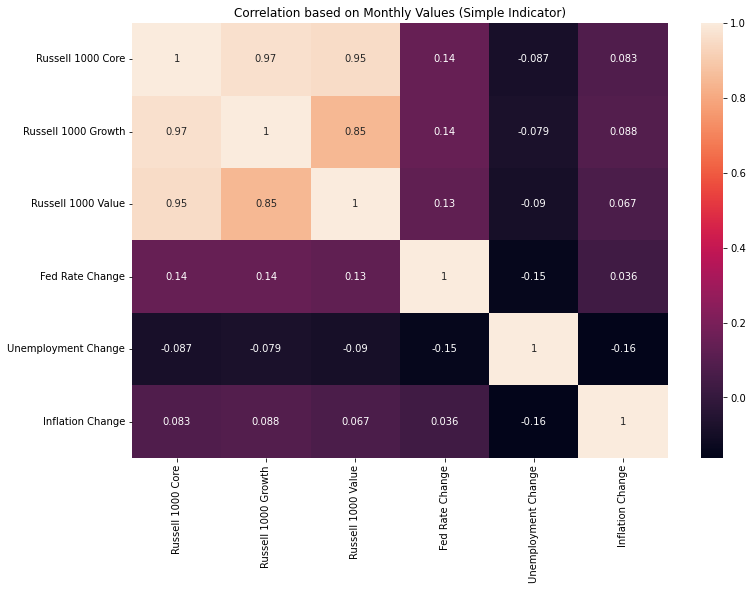

In [39]:
# Plots monthly simple correlation as heatmap

market_data_corr = simple_monthly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True).set_title('Correlation based on Monthly Values (Simple Indicator)')

plt.show()

## Based on the available monthly data : 
* Core is highly correlated to both Growth and Value, but Value and Growth appear to be able to provide diversification benefits to each other. 
* Growth stocks are expected to outperform during times of rising inflation
* Value stocks can provide a hedge during times of falling inflation. 
* Value stocks should outperform during times of falling unemployment
* Growth stocks will provide a hedge during times of rising unemployment. 
* All strategies behave simlarly to changes in Interest Rates - Will ignore. 

# Correlation based on Quarterly Values (Simple Indicator)

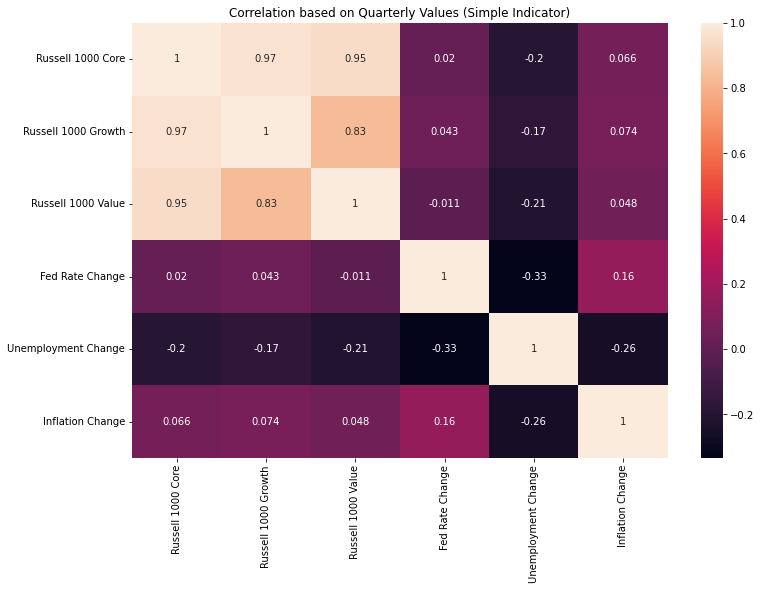

In [40]:
# Plots quarterly simple correlation as heatmap

market_data_corr = simple_quarterly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True).set_title('Correlation based on Quarterly Values (Simple Indicator)')

plt.show()

## Based on the quarterly monthly data : 
* Core is highly correlated to both Growth and Value, but Value and Growth appear to be able to provide diversification benefits to each other. 
* Growth stocks are expected to outperform during times of rising inflation
* Value stocks can provide a hedge during times of falling inflation. 
* Value stocks should outperform during times of falling unemployment
* Growth stocks will provide a hedge during times of rising unemployment. 
* On a quarterly basis Growth appears to be more positively correlate to Fed Rate Changes, might overweight.  

# Correlation based on Yearly Values (Simple Indicator)

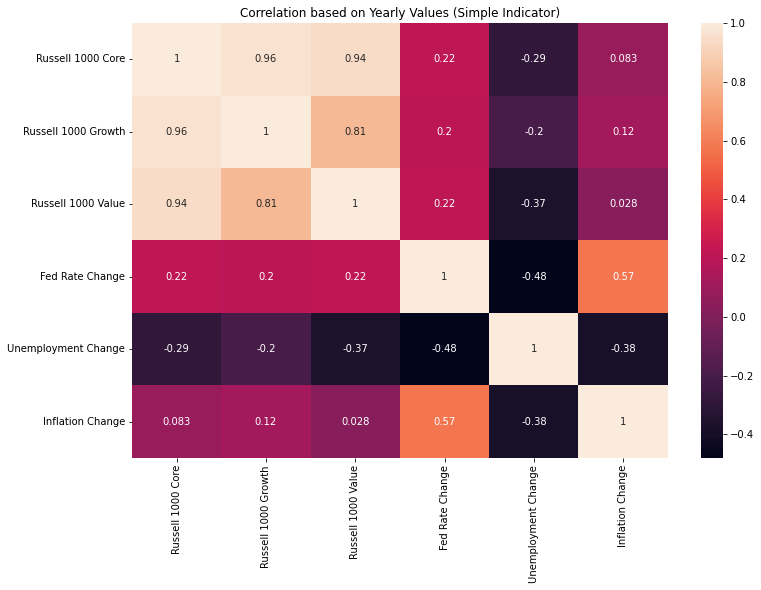

In [41]:
# Plots yearly simple correlation as heatmap

market_data_corr = simple_yearly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True).set_title('Correlation based on Yearly Values (Simple Indicator)')
plt.show()

## Based on the available yearly data : 
* Core is highly correlated to both Growth and Value, but Value and Growth appear to be able to provide diversification benefits to each other. 
* Growth stocks are expected to outperform during times of rising inflation
* Value stocks can provide a hedge during times of falling inflation. 
* Value stocks should outperform during times of falling unemployment
* Growth stocks will provide a hedge during times of rising unemployment. 
* All strategies behave simlarly to changes in Interest Rates - slight edge to value / core. 

# Correlation based on Monthly Values (Relative Indicators)

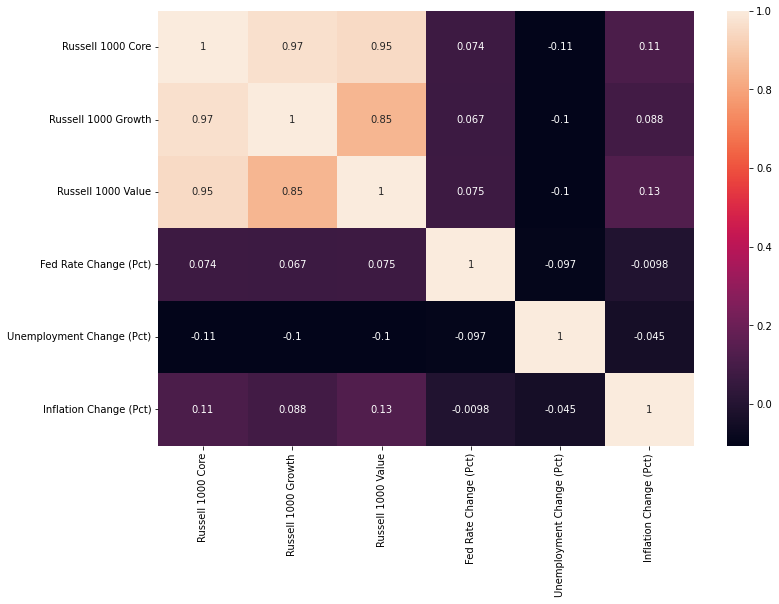

In [42]:
# Plots monthly relative correlation as heatmap

market_data_corr = relative_monthly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True)

plt.show()

# Correlation based on Quarterly Values (Relative Indicators)

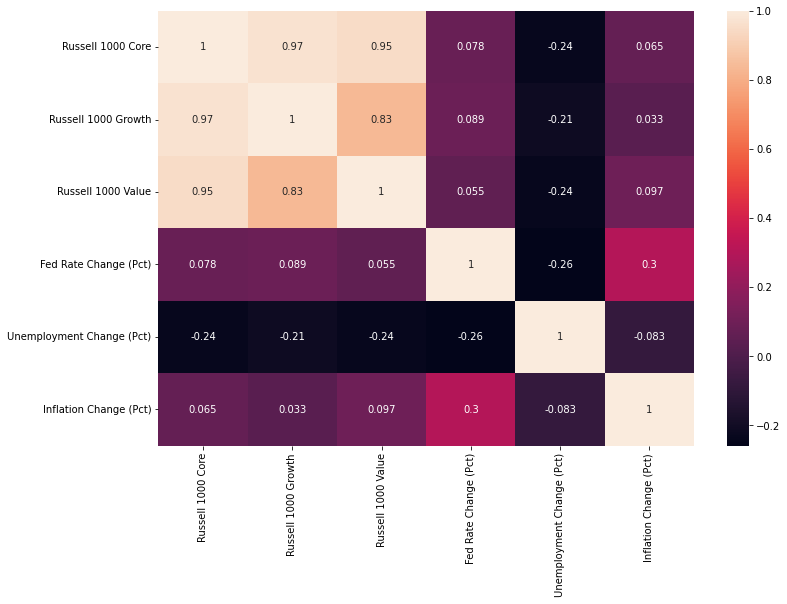

In [43]:
# Plots quarterly relative correlation as heatmap

market_data_corr = relative_quarterly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True)

plt.show()

# Correlation based on Yearly Values (Relative Indicators)

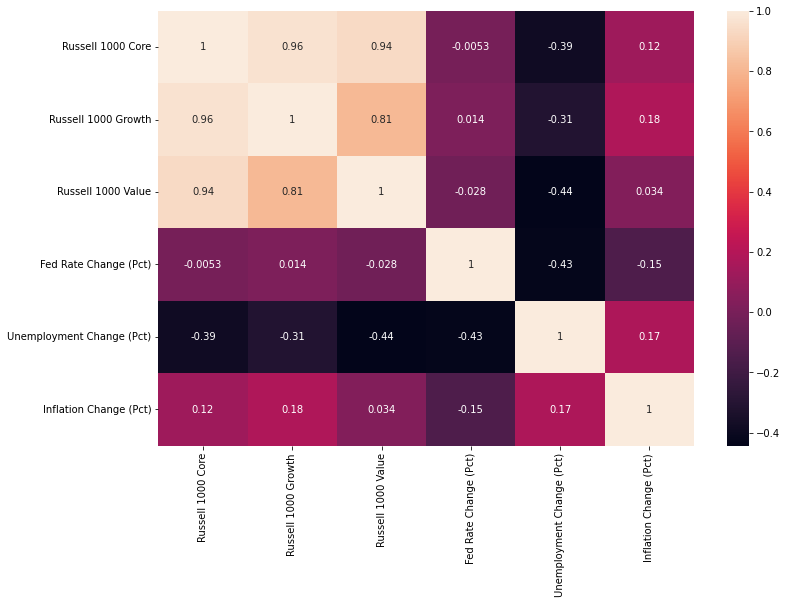

In [44]:
# Plots monthly relative correlation as heatmap

market_data_corr = relative_yearly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True)

plt.show()


# Momentum Pick #1 (Pure Index)

In [45]:
# Picks which index to buy based on last months max return, then replaces first value with Russell 1000 Value as no prior month return was available.

momentum = simple_quarterly_md[['Russell 1000 Core','Russell 1000 Value','Russell 1000 Growth']].copy()
momentum['Pick'] = momentum[['Russell 1000 Core','Russell 1000 Value','Russell 1000 Growth']].shift().idxmax(axis=1)
momentum['Pick'] = momentum['Pick'].replace(np.nan, 'Russell 1000 Value')
#pd.set_option("display.max_rows", None, "display.max_columns", None)

momentum

Russell 1000 Core  Russell 1000 Value  Russell 1000 Growth  \
date                                                                     
1979-03-31           0.079500            0.094028             0.064693   
1979-06-30           0.037425            0.046438             0.028440   
1979-09-30           0.080900            0.079606             0.082252   
1979-12-31           0.010574           -0.024672             0.045566   
1980-03-31          -0.056568           -0.060193            -0.052713   
...                       ...                 ...                  ...   
2014-12-31           0.048811            0.049801             0.047843   
2015-03-31           0.015916           -0.007219             0.038376   
2015-06-30           0.001134            0.001084             0.001200   
2015-09-30          -0.068293           -0.083950            -0.052901   
2015-12-31           0.064969            0.056352             0.073171   

                           Pick  
date                             
1979-03-31   Russell 1000 Value  
1979-06-30   Russell 1000 Value  
1979-09-30   Russell 1000 Value  
1979-12-31  Russell 1000 Growth  
1980-03-31  Russell 1000 Growth  
...                         ...  
2014-12-31  Russell 1000 Growth  
2015-03-31   Russell 1000 Value  
2015-06-30  Russell 1000 Growth  
2015-09-30  Russell 1000 Growth  
2015-12-31  Russell 1000 Growth  

[148 rows x 4 columns]

In [46]:
# Creates trade flag based on if last month's pick = this month's pick. If not Trade flag is created. If so, Hold.

momentum.loc[momentum['Pick'] != momentum['Pick'].shift(), "Trade/Hold"] = "Trade"
momentum = momentum.replace(np.nan, 'X')

momentum

Russell 1000 Core  Russell 1000 Value  Russell 1000 Growth  \
date                                                                     
1979-03-31           0.079500            0.094028             0.064693   
1979-06-30           0.037425            0.046438             0.028440   
1979-09-30           0.080900            0.079606             0.082252   
1979-12-31           0.010574           -0.024672             0.045566   
1980-03-31          -0.056568           -0.060193            -0.052713   
...                       ...                 ...                  ...   
2014-12-31           0.048811            0.049801             0.047843   
2015-03-31           0.015916           -0.007219             0.038376   
2015-06-30           0.001134            0.001084             0.001200   
2015-09-30          -0.068293           -0.083950            -0.052901   
2015-12-31           0.064969            0.056352             0.073171   

                           Pick Trade/Hold  
date                                        
1979-03-31   Russell 1000 Value      Trade  
1979-06-30   Russell 1000 Value          X  
1979-09-30   Russell 1000 Value          X  
1979-12-31  Russell 1000 Growth      Trade  
1980-03-31  Russell 1000 Growth          X  
...                         ...        ...  
2014-12-31  Russell 1000 Growth          X  
2015-03-31   Russell 1000 Value      Trade  
2015-06-30  Russell 1000 Growth      Trade  
2015-09-30  Russell 1000 Growth          X  
2015-12-31  Russell 1000 Growth          X  

[148 rows x 5 columns]

In [47]:
# Creates row showing the return of the selected strategy based on the pick column. 

idx, col = pd.factorize(momentum['Pick'])
momentum['Selection Return'] = momentum.reindex(columns=col).to_numpy()[np.arange(len(momentum)), idx]

momentum

Russell 1000 Core  Russell 1000 Value  Russell 1000 Growth  \
date                                                                     
1979-03-31           0.079500            0.094028             0.064693   
1979-06-30           0.037425            0.046438             0.028440   
1979-09-30           0.080900            0.079606             0.082252   
1979-12-31           0.010574           -0.024672             0.045566   
1980-03-31          -0.056568           -0.060193            -0.052713   
...                       ...                 ...                  ...   
2014-12-31           0.048811            0.049801             0.047843   
2015-03-31           0.015916           -0.007219             0.038376   
2015-06-30           0.001134            0.001084             0.001200   
2015-09-30          -0.068293           -0.083950            -0.052901   
2015-12-31           0.064969            0.056352             0.073171   

                           Pick Trade/Hold  Selection Return  
date                                                          
1979-03-31   Russell 1000 Value      Trade          0.094028  
1979-06-30   Russell 1000 Value          X          0.046438  
1979-09-30   Russell 1000 Value          X          0.079606  
1979-12-31  Russell 1000 Growth      Trade          0.045566  
1980-03-31  Russell 1000 Growth          X         -0.052713  
...                         ...        ...               ...  
2014-12-31  Russell 1000 Growth          X          0.047843  
2015-03-31   Russell 1000 Value      Trade         -0.007219  
2015-06-30  Russell 1000 Growth      Trade          0.001200  
2015-09-30  Russell 1000 Growth          X         -0.052901  
2015-12-31  Russell 1000 Growth          X          0.073171  

[148 rows x 6 columns]

In [48]:
momentum_results = momentum[['Russell 1000 Core','Selection Return']].copy()
momentum_results.loc[momentum_results.index[0], 'Core Portfolio Value'] = 100
momentum_results.loc[momentum_results.index[0], 'Selection Portfolio Value'] = 100
momentum_results = momentum_results.copy()
momentum_results.loc[datetime.datetime.strptime('1978-12-31', '%Y-%m-%d').date()] = [0,0, 100,100]  # adding a row
momentum_results = momentum_results.sort_index()
for i in range(momentum_results.index.size - 1):
    momentum_results['Core Portfolio Value'].iloc[i+1] = (momentum_results['Russell 1000 Core'].apply(percentagecompound).iloc[i+1] * momentum_results['Core Portfolio Value'].iloc[i])
    momentum_results['Selection Portfolio Value'].iloc[i+1] = (momentum_results['Selection Return'].apply(percentagecompound).iloc[i+1] * momentum_results['Selection Portfolio Value'].iloc[i])

momentum_results    


Russell 1000 Core  Selection Return  Core Portfolio Value  \
date                                                                    
1978-12-31           0.000000          0.000000            100.000000   
1979-03-31           0.079500          0.094028            107.950000   
1979-06-30           0.037425          0.046438            111.990000   
1979-09-30           0.080900          0.079606            121.050000   
1979-12-31           0.010574          0.045566            122.330000   
...                       ...               ...                   ...   
2014-12-31           0.048811          0.047843           6015.980856   
2015-03-31           0.015916         -0.007219           6111.730693   
2015-06-30           0.001134          0.001200           6118.662755   
2015-09-30          -0.068293         -0.052901           5700.800601   
2015-12-31           0.064969          0.073171           6071.176340   

            Selection Portfolio Value  
date                                   
1978-12-31                 100.000000  
1979-03-31                 109.402847  
1979-06-30                 114.483277  
1979-09-30                 123.596806  
1979-12-31                 129.228561  
...                               ...  
2014-12-31                5504.484783  
2015-03-31                5464.746358  
2015-06-30                5471.306700  
2015-09-30                5181.870717  
2015-12-31                5561.034411  

[149 rows x 4 columns]

In [49]:
# Plots all 3 portfolio returns

#subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig = px.bar(momentum.apply(hundred).reset_index(), x="date", y=["Russell 1000 Core",'Russell 1000 Value','Russell 1000 Growth'],
            barmode='group',
             height=400, 
            ) 
#subfig.update_layout(title= 'Yearly Returns (Pct)')
#fig.update_traces(line_color='#0000ff', line_width=5)
#fig2.update_traces(yaxis="y2",line_color='#0F0A09')
#subfig.add_traces(fig.data)
#subfig.update_xaxes(nticks=37)
#subfig.update_xaxes(tickangle=90)
#subfig.show()
fig.show()

In [50]:
#Plots selected portfolio vs Russell 1000 Core over period. 

fig = px.line(momentum_results.reset_index(), x = 'date', y=['Core Portfolio Value','Selection Portfolio Value'], title='Core vs Momentum v1')
fig.show()

In [51]:
#Shows ending value of $100

momentum_results[['Core Portfolio Value','Selection Portfolio Value']].iloc[-1].round(2).reset_index().rename(columns = {'index':'Portfolio', 0:'Ending Port Val'}).set_index('Portfolio').style.set_caption('Value of $100')

In [52]:
#Shows Stats of Momentum strategy

momentum_Ret = ((momentum[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].apply(percentagecompound).prod() ** (1/time_period) - 1)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Return'})
momentum_Std = (momentum[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].std().apply(annualfromquarterlystd)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Std'})
momentum_Stats = pd.merge(momentum_Ret, momentum_Std, on='Strategy', how = 'left')
momentum_Stats['Sharpe'] = ((momentum_Stats['Annualized Return'] - 2) / momentum_Stats['Annualized Std']).round(2)
momentum_Stats = momentum_Stats.set_index('Strategy')
momentum_Stats


Annualized Return  Annualized Std  Sharpe
Strategy                                                      
Russell 1000 Core            11.736886       16.350467    0.60
Russell 1000 Growth          11.047046       18.648083    0.49
Russell 1000 Value           12.048407       15.510075    0.65
Selection Return             11.472147       17.264132    0.55

In [53]:
#Shows momentum trade data

momentum_trades = momentum[['Russell 1000 Core','Trade/Hold']].groupby('Trade/Hold').count().rename(columns = {'Russell 1000 Core':'Total'})
momentum_trades['Average Yearly Trades'] = momentum_trades['Total'] / time_period
momentum_trades['Average Yearly Trades'] = momentum_trades['Average Yearly Trades'].round(1)
momentum_trades = momentum_trades.drop('X')
momentum_trades


Total  Average Yearly Trades
Trade/Hold                              
Trade          78                    2.1

In [54]:
#Trade schedule

momentum_trade_pivot = momentum[['Trade/Hold','Pick']].reset_index()
momentum_trade_pivot.loc[momentum_trade_pivot['Trade/Hold'] == 'Trade', 'Trade/Hold' ] = momentum_trade_pivot['Trade/Hold'] + " - " + momentum_trade_pivot['Pick']#momentum_2_trade_pivot = momentum_2_trade_pivot.drop(columns = 'Pick')
momentum_trade_pivot = momentum_trade_pivot.drop(columns = 'Pick')
momentum_trade_pivot['Month'] = momentum_trade_pivot['date'].astype(str).str.split('-').str[1]
momentum_trade_pivot['Year'] = momentum_trade_pivot['date'].astype(str).str.split('-').str[0]
momentum_trade_pivot = momentum_trade_pivot.drop(columns = 'date').pivot(index = 'Year', columns = 'Month').rename(columns = {'03': 'Qtr 1','06': 'Qtr 2','09': 'Qtr 3','12': 'Qtr 4'}).style.apply(lambda x: ["background: green" if 'Trade' in value else "" for value in x], axis = 1)
momentum_trade_pivot


## Notes
Picking solely based on last quarter's winner does not appear to be a winning strategy over the time period. 

# Momentum Pick #2 (Weighted Index)

I will now create weighted portfolios to allow for diversification, and test if it is possible to beat the Russell 1000 Core. 

In [55]:
#Create returns data based on chosen portfolio weights. 

momentum_weighted = momentum.drop(columns = 'Selection Return').copy()
momentum_weighted['Value Weighted Return'] = momentum_weighted['Russell 1000 Core'] * .02 + momentum_weighted['Russell 1000 Value'] * .97 + momentum_weighted['Russell 1000 Growth'] * .01
momentum_weighted['Growth Weighted Return'] = momentum_weighted['Russell 1000 Core'] * .1 + momentum_weighted['Russell 1000 Growth'] * .2 + momentum_weighted['Russell 1000 Value'] * .7 
momentum_weighted['Core Weighted Return'] = momentum_weighted['Russell 1000 Core'] * .2 + momentum_weighted['Russell 1000 Value'] * .8 + momentum_weighted['Russell 1000 Growth'] * .0

momentum_weighted


Russell 1000 Core  Russell 1000 Value  Russell 1000 Growth  \
date                                                                     
1979-03-31           0.079500            0.094028             0.064693   
1979-06-30           0.037425            0.046438             0.028440   
1979-09-30           0.080900            0.079606             0.082252   
1979-12-31           0.010574           -0.024672             0.045566   
1980-03-31          -0.056568           -0.060193            -0.052713   
...                       ...                 ...                  ...   
2014-12-31           0.048811            0.049801             0.047843   
2015-03-31           0.015916           -0.007219             0.038376   
2015-06-30           0.001134            0.001084             0.001200   
2015-09-30          -0.068293           -0.083950            -0.052901   
2015-12-31           0.064969            0.056352             0.073171   

                           Pick Trade/Hold  Value Weighted Return  \
date                                                                
1979-03-31   Russell 1000 Value      Trade               0.093445   
1979-06-30   Russell 1000 Value          X               0.046078   
1979-09-30   Russell 1000 Value          X               0.079658   
1979-12-31  Russell 1000 Growth      Trade              -0.023265   
1980-03-31  Russell 1000 Growth          X              -0.060046   
...                         ...        ...                    ...   
2014-12-31  Russell 1000 Growth          X               0.049762   
2015-03-31   Russell 1000 Value      Trade              -0.006301   
2015-06-30  Russell 1000 Growth      Trade               0.001086   
2015-09-30  Russell 1000 Growth          X              -0.083326   
2015-12-31  Russell 1000 Growth          X               0.056693   

            Growth Weighted Return  Core Weighted Return  
date                                                      
1979-03-31                0.086708              0.091123  
1979-06-30                0.041937              0.044635  
1979-09-30                0.080264              0.079865  
1979-12-31               -0.007100             -0.017623  
1980-03-31               -0.058334             -0.059468  
...                            ...                   ...  
2014-12-31                0.049311              0.049603  
2015-03-31                0.004213             -0.002592  
2015-06-30                0.001112              0.001094  
2015-09-30               -0.076174             -0.080818  
2015-12-31                0.060578              0.058076  

[148 rows x 8 columns]

In [56]:
#Find return for selected portfolio

momentum_weighted.loc[momentum_weighted['Pick'] == 'Russell 1000 Core', "Selection Return"] =  momentum_weighted['Russell 1000 Core']
momentum_weighted.loc[momentum_weighted['Pick'] == 'Russell 1000 Growth', "Selection Return"] =  momentum_weighted['Growth Weighted Return']
momentum_weighted.loc[momentum_weighted['Pick'] == 'Russell 1000 Value', "Selection Return"] =  momentum_weighted['Value Weighted Return']
momentum_weighted['Pick'] = momentum_weighted['Pick'].apply(portswitch)
momentum_weighted


Russell 1000 Core  Russell 1000 Value  Russell 1000 Growth  \
date                                                                     
1979-03-31           0.079500            0.094028             0.064693   
1979-06-30           0.037425            0.046438             0.028440   
1979-09-30           0.080900            0.079606             0.082252   
1979-12-31           0.010574           -0.024672             0.045566   
1980-03-31          -0.056568           -0.060193            -0.052713   
...                       ...                 ...                  ...   
2014-12-31           0.048811            0.049801             0.047843   
2015-03-31           0.015916           -0.007219             0.038376   
2015-06-30           0.001134            0.001084             0.001200   
2015-09-30          -0.068293           -0.083950            -0.052901   
2015-12-31           0.064969            0.056352             0.073171   

                       Pick Trade/Hold  Value Weighted Return  \
date                                                            
1979-03-31   Value Weighted      Trade               0.093445   
1979-06-30   Value Weighted          X               0.046078   
1979-09-30   Value Weighted          X               0.079658   
1979-12-31  Growth Weighted      Trade              -0.023265   
1980-03-31  Growth Weighted          X              -0.060046   
...                     ...        ...                    ...   
2014-12-31  Growth Weighted          X               0.049762   
2015-03-31   Value Weighted      Trade              -0.006301   
2015-06-30  Growth Weighted      Trade               0.001086   
2015-09-30  Growth Weighted          X              -0.083326   
2015-12-31  Growth Weighted          X               0.056693   

            Growth Weighted Return  Core Weighted Return  Selection Return  
date                                                                        
1979-03-31                0.086708              0.091123          0.093445  
1979-06-30                0.041937              0.044635          0.046078  
1979-09-30                0.080264              0.079865          0.079658  
1979-12-31               -0.007100             -0.017623         -0.007100  
1980-03-31               -0.058334             -0.059468         -0.058334  
...                            ...                   ...               ...  
2014-12-31                0.049311              0.049603          0.049311  
2015-03-31                0.004213             -0.002592         -0.006301  
2015-06-30                0.001112              0.001094          0.001112  
2015-09-30               -0.076174             -0.080818         -0.076174  
2015-12-31                0.060578              0.058076          0.060578  

[148 rows x 9 columns]

In [57]:
#Creates result table, finding value of $100

momentum_weighted_results = momentum_weighted[['Russell 1000 Core','Selection Return']].copy()
momentum_weighted_results.loc[momentum_weighted_results.index[0], 'Core Portfolio Value'] = 100
momentum_weighted_results.loc[momentum_weighted_results.index[0], 'Selection Portfolio Value'] = 100
momentum_weighted_results2 = momentum_weighted_results.copy()
momentum_weighted_results2.loc[datetime.datetime.strptime('1978-12-31', '%Y-%m-%d').date()] = [0,0, 100,100]  # adding a row
momentum_weighted_results2 = momentum_weighted_results2.sort_index()
for i in range(momentum_weighted_results2.index.size - 1):
    momentum_weighted_results2['Core Portfolio Value'].iloc[i+1] = (momentum_weighted_results2['Russell 1000 Core'].apply(percentagecompound).iloc[i+1] * momentum_weighted_results2['Core Portfolio Value'].iloc[i])
    momentum_weighted_results2['Selection Portfolio Value'].iloc[i+1] = (momentum_weighted_results2['Selection Return'].apply(percentagecompound).iloc[i+1] * momentum_weighted_results2['Selection Portfolio Value'].iloc[i])

momentum_weighted_results2    


Russell 1000 Core  Selection Return  Core Portfolio Value  \
date                                                                    
1978-12-31           0.000000          0.000000            100.000000   
1979-03-31           0.079500          0.093445            107.950000   
1979-06-30           0.037425          0.046078            111.990000   
1979-09-30           0.080900          0.079658            121.050000   
1979-12-31           0.010574         -0.007100            122.330000   
...                       ...               ...                   ...   
2014-12-31           0.048811          0.049311           6015.980856   
2015-03-31           0.015916         -0.006301           6111.730693   
2015-06-30           0.001134          0.001112           6118.662755   
2015-09-30          -0.068293         -0.076174           5700.800601   
2015-12-31           0.064969          0.060578           6071.176340   

            Selection Portfolio Value  
date                                   
1978-12-31                 100.000000  
1979-03-31                 109.344454  
1979-06-30                 114.382783  
1979-09-30                 123.494299  
1979-12-31                 122.617480  
...                               ...  
2014-12-31                6690.608906  
2015-03-31                6648.453922  
2015-06-30                6655.847186  
2015-09-30                6148.843136  
2015-12-31                6521.325973  

[149 rows x 4 columns]

In [58]:
#creates list used to plot trade lines. 

lines_test = momentum_weighted.reset_index()[['date','Trade/Hold']].set_index('date').loc[momentum_weighted['Trade/Hold'] == 'Trade'].drop(columns = 'Trade/Hold').reset_index()
lines_test['date'] = lines_test['date'].astype(str)
lines = lines_test['date'].values


In [59]:
#plots value of $100 with trade lines. 

fig = px.line(momentum_weighted_results2.reset_index(), x = 'date', y=['Core Portfolio Value','Selection Portfolio Value'], title='Core vs Momentum v2')

for i in range(len(lines)):
    fig.add_vline(x=lines[i], line_width=1, line_dash="solid", line_color="black")

fig.update_xaxes(nticks=30)
fig.update_xaxes(tickangle=45)

fig.show()


In [60]:
#Plots selected portfolio vs Russell 1000 Core over period. 

fig = px.line(momentum_weighted_results2.reset_index(), x = 'date', y=['Core Portfolio Value','Selection Portfolio Value'], title='Core vs Momentum v2')
fig.show()

In [61]:
#Value of $100

momentum_weighted_results2[['Core Portfolio Value','Selection Portfolio Value']].iloc[-1].round(2).reset_index().rename(columns = {'index':'Portfolio', 0:'Ending Port Val'}).set_index('Portfolio').style.set_caption('Value of $100')

In [62]:
#momentum_weighted_trade data 

momentum_weighted_trades = momentum_weighted[['Russell 1000 Core','Trade/Hold']].groupby('Trade/Hold').count().rename(columns = {'Russell 1000 Core':'Total'})
momentum_weighted_trades['Average Yearly Trades'] = momentum_weighted_trades['Total'] / time_period
momentum_weighted_trades['Average Yearly Trades'] = momentum_weighted_trades['Average Yearly Trades'].round(1)
momentum_weighted_trades = momentum_weighted_trades.drop('X')
momentum_weighted_trades


Total  Average Yearly Trades
Trade/Hold                              
Trade          78                    2.1

In [63]:
#Generates stats for momentum weighted strat

momentum_weighted_Ret = ((momentum_weighted[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].apply(percentagecompound).prod() ** (1/time_period) - 1)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Return'})
momentum_weighted_Std = (momentum_weighted[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].std().apply(annualfromquarterlystd)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Std'})
momentum_weighted_Stats = pd.merge(momentum_weighted_Ret, momentum_weighted_Std, on='Strategy', how = 'left')
momentum_weighted_Stats['Sharpe'] = ((momentum_weighted_Stats['Annualized Return'] - 2) / momentum_weighted_Stats['Annualized Std']).round(2)
momentum_weighted_Stats = momentum_weighted_Stats.set_index('Strategy')
momentum_weighted_Stats

Annualized Return  Annualized Std  Sharpe
Strategy                                                      
Russell 1000 Core            11.736886       16.350467    0.60
Russell 1000 Growth          11.047046       18.648083    0.49
Russell 1000 Value           12.048407       15.510075    0.65
Selection Return             11.953095       15.659660    0.64

In [64]:
#Creates trade schedule 

momentum_2_trade_pivot = momentum_weighted[['Trade/Hold','Pick']].reset_index()
momentum_2_trade_pivot.loc[momentum_2_trade_pivot['Trade/Hold'] == 'Trade', 'Trade/Hold' ] = momentum_2_trade_pivot['Trade/Hold'] + " - " + momentum_2_trade_pivot['Pick']#momentum_2_trade_pivot = momentum_2_trade_pivot.drop(columns = 'Pick')
momentum_2_trade_pivot = momentum_2_trade_pivot.drop(columns = 'Pick')
momentum_2_trade_pivot['Month'] = momentum_2_trade_pivot['date'].astype(str).str.split('-').str[1]
momentum_2_trade_pivot['Year'] = momentum_2_trade_pivot['date'].astype(str).str.split('-').str[0]
momentum_2_trade_pivot = momentum_2_trade_pivot.drop(columns = 'date').pivot(index = 'Year', columns = 'Month').rename(columns = {'03': 'Qtr 1','06': 'Qtr 2','09': 'Qtr 3','12': 'Qtr 4'}).style.apply(lambda x: ["background: green" if 'Trade' in value else "" for value in x], axis = 1)
momentum_2_trade_pivot

# Efficient Frontier

In [65]:
# Determines annualized portfolio performance based on monthly returns. 

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *12
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12)
    return std, returns

#Loops through creating randomly weighted portfolios

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(3)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [66]:
# assigns values for simulated EF 

table = simple_monthly_md[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value']].apply(hundred)
returns = simple_monthly_md[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value']].apply(hundred)
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0

In [67]:
# Prints result and plot Efficient Frontier. 

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualized Return:", round(rp,2))
    print ("Annualized Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualized Return:", round(rp_min,2))
    print ("Annualized Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualized volatility')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 12.51
Annualized Volatility: 14.64


            Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value
allocation               1.23                 0.21               98.56
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 12.49
Annualized Volatility: 14.64


            Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value
allocation              10.62                 0.12               89.26


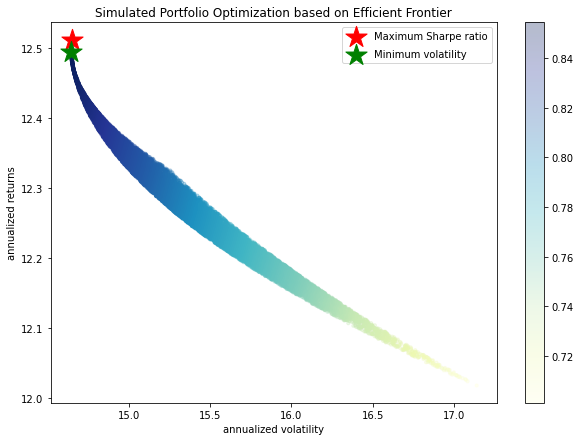

In [68]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


# Indicator Pick #1


In [69]:
# Copies quarterly market data in factor pick dataframe. 
indicator_pick = simple_quarterly_md.copy()

In [70]:
# Assigns values to "Flags" used to determine which portfolio to use. 
# 1 = Value Weighted
# - 1 = Growth Weighted
# 0 = uncertain

indicator_pick.loc[(indicator_pick['Fed Rate Change']<0),'Fed Flag'] = 1
indicator_pick.loc[(indicator_pick['Fed Rate Change']>0),'Fed Flag'] = -1
indicator_pick.loc[(indicator_pick['Fed Rate Change']==0),'Fed Flag'] = 0
indicator_pick.loc[(indicator_pick['Unemployment Change']<0),'Unemployment Flag'] = 1
indicator_pick.loc[(indicator_pick['Unemployment Change']>0),'Unemployment Flag'] = -1
indicator_pick.loc[(indicator_pick['Unemployment Change']==0),'Unemployment Flag'] = 0
indicator_pick.loc[(indicator_pick['Inflation Change']<0),'Inflation Flag'] = 1
indicator_pick.loc[(indicator_pick['Inflation Change']>0),'Inflation Flag'] = -1
indicator_pick.loc[(indicator_pick['Inflation Change']==0),'Inflation Flag'] = 0

In [71]:
#Sums Flags to create a prediction
#Positive numbers and 0s will use the Value weighted portfolio.
#Negative numbers will use growth weighted. 

indicator_pick['Flag_Sum'] = indicator_pick['Fed Flag'] + indicator_pick['Unemployment Flag'] + indicator_pick['Inflation Flag']
indicator_pick


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            Fed Rate Change  Unemployment Change  Inflation Change  Fed Flag  \
date                                                                           
1979-03-31            -0.14                 -0.1               1.2       1.0   
1979-06-30             0.38                 -0.1               0.8      -1.0   
1979-09-30             4.01                  0.3               0.8      -1.0   
1979-12-31            -1.42                  0.3               1.8       1.0   
1980-03-31             1.24                  0.6               0.8      -1.0   
...                     ...                  ...               ...       ...   
2014-12-31            -0.01                  0.0              -1.8       1.0   
2015-03-31             0.02                 -0.3              -0.1      -1.0   
2015-06-30             0.00                 -0.2               0.4       0.0   
2015-09-30            -0.01                 -0.2               0.0       1.0   
2015-12-31             0.22                 -0.2               1.2      -1.0   

            Unemployment Flag  Inflation Flag  Flag_Sum  
date                                                     
1979-03-31                1.0            -1.0       1.0  
1979-06-30                1.0            -1.0      -1.0  
1979-09-30               -1.0            -1.0      -3.0  
1979-12-31               -1.0            -1.0      -1.0  
1980-03-31               -1.0            -1.0      -3.0  
...                       ...             ...       ...  
2014-12-31                0.0             1.0       2.0  
2015-03-31                1.0             1.0       1.0  
2015-06-30                1.0            -1.0       0.0  
2015-09-30                1.0             0.0       2.0  
2015-12-31                1.0            -1.0      -1.0  

[148 rows x 10 columns]

In [72]:
# Assigns favored portfolios based on Flag_Sum column of previous month. 

indicator_pick.loc[(indicator_pick['Flag_Sum'].shift() >0),'Favored'] = 'Russell 1000 Value'
indicator_pick.loc[(indicator_pick['Flag_Sum'].shift() ==0),'Favored'] = 'Russell 1000 Value'
indicator_pick.loc[(indicator_pick['Flag_Sum'].shift() <0),'Favored'] = 'Russell 1000 Growth'
indicator_pick = indicator_pick.replace(np.nan, 'Russell 1000 Value')
indicator_pick

Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            Fed Rate Change  Unemployment Change  Inflation Change  Fed Flag  \
date                                                                           
1979-03-31            -0.14                 -0.1               1.2       1.0   
1979-06-30             0.38                 -0.1               0.8      -1.0   
1979-09-30             4.01                  0.3               0.8      -1.0   
1979-12-31            -1.42                  0.3               1.8       1.0   
1980-03-31             1.24                  0.6               0.8      -1.0   
...                     ...                  ...               ...       ...   
2014-12-31            -0.01                  0.0              -1.8       1.0   
2015-03-31             0.02                 -0.3              -0.1      -1.0   
2015-06-30             0.00                 -0.2               0.4       0.0   
2015-09-30            -0.01                 -0.2               0.0       1.0   
2015-12-31             0.22                 -0.2               1.2      -1.0   

            Unemployment Flag  Inflation Flag  Flag_Sum              Favored  
date                                                                          
1979-03-31                1.0            -1.0       1.0   Russell 1000 Value  
1979-06-30                1.0            -1.0      -1.0   Russell 1000 Value  
1979-09-30               -1.0            -1.0      -3.0  Russell 1000 Growth  
1979-12-31               -1.0            -1.0      -1.0  Russell 1000 Growth  
1980-03-31               -1.0            -1.0      -3.0  Russell 1000 Growth  
...                       ...             ...       ...                  ...  
2014-12-31                0.0             1.0       2.0   Russell 1000 Value  
2015-03-31                1.0             1.0       1.0   Russell 1000 Value  
2015-06-30                1.0            -1.0       0.0   Russell 1000 Value  
2015-09-30                1.0             0.0       2.0   Russell 1000 Value  
2015-12-31                1.0            -1.0      -1.0   Russell 1000 Value  

[148 rows x 11 columns]

In [73]:
# Checks to see which portfolio was held last quarter and determines if a Trade is necessary. 

indicator_pick.loc[indicator_pick['Favored'] != indicator_pick['Favored'].shift(), "Trade/Hold"] = "Trade"
indicator_pick = indicator_pick.replace(np.nan, 'X')

indicator_pick

Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            Fed Rate Change  Unemployment Change  Inflation Change  Fed Flag  \
date                                                                           
1979-03-31            -0.14                 -0.1               1.2       1.0   
1979-06-30             0.38                 -0.1               0.8      -1.0   
1979-09-30             4.01                  0.3               0.8      -1.0   
1979-12-31            -1.42                  0.3               1.8       1.0   
1980-03-31             1.24                  0.6               0.8      -1.0   
...                     ...                  ...               ...       ...   
2014-12-31            -0.01                  0.0              -1.8       1.0   
2015-03-31             0.02                 -0.3              -0.1      -1.0   
2015-06-30             0.00                 -0.2               0.4       0.0   
2015-09-30            -0.01                 -0.2               0.0       1.0   
2015-12-31             0.22                 -0.2               1.2      -1.0   

            Unemployment Flag  Inflation Flag  Flag_Sum              Favored  \
date                                                                           
1979-03-31                1.0            -1.0       1.0   Russell 1000 Value   
1979-06-30                1.0            -1.0      -1.0   Russell 1000 Value   
1979-09-30               -1.0            -1.0      -3.0  Russell 1000 Growth   
1979-12-31               -1.0            -1.0      -1.0  Russell 1000 Growth   
1980-03-31               -1.0            -1.0      -3.0  Russell 1000 Growth   
...                       ...             ...       ...                  ...   
2014-12-31                0.0             1.0       2.0   Russell 1000 Value   
2015-03-31                1.0             1.0       1.0   Russell 1000 Value   
2015-06-30                1.0            -1.0       0.0   Russell 1000 Value   
2015-09-30                1.0             0.0       2.0   Russell 1000 Value   
2015-12-31                1.0            -1.0      -1.0   Russell 1000 Value   

           Trade/Hold  
date                   
1979-03-31      Trade  
1979-06-30          X  
1979-09-30      Trade  
1979-12-31          X  
1980-03-31          X  
...               ...  
2014-12-31          X  
2015-03-31          X  
2015-06-30          X  
2015-09-30          X  
2015-12-31          X  

[148 rows x 12 columns]

In [74]:
# assigns portfolio weights 

indicator_pick['Value Weighted Return'] = indicator_pick['Russell 1000 Core'] * .02 + indicator_pick['Russell 1000 Value'] * .97 + indicator_pick['Russell 1000 Growth'] * .01
indicator_pick['Growth Weighted Return'] = indicator_pick['Russell 1000 Core'] * .1 + indicator_pick['Russell 1000 Growth'] * .2 + indicator_pick['Russell 1000 Value'] * .7 
indicator_pick['Core Weighted Return'] = indicator_pick['Russell 1000 Core'] * .2 + indicator_pick['Russell 1000 Value'] * .8 + indicator_pick['Russell 1000 Growth'] * .0

# Creates columns with performance of all 3 strategies

indicator_pick.loc[indicator_pick['Favored'] == 'Russell 1000 Core', "Selection Return"] =  indicator_pick['Value Weighted Return']
indicator_pick.loc[indicator_pick['Favored'] == 'Russell 1000 Growth', "Selection Return"] =  indicator_pick['Growth Weighted Return']
indicator_pick.loc[indicator_pick['Favored'] == 'Russell 1000 Value', "Selection Return"] =  indicator_pick['Value Weighted Return']

indicator_pick['Favored'] = indicator_pick['Favored'].apply(portswitch)

indicator_pick


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            Fed Rate Change  Unemployment Change  Inflation Change  Fed Flag  \
date                                                                           
1979-03-31            -0.14                 -0.1               1.2       1.0   
1979-06-30             0.38                 -0.1               0.8      -1.0   
1979-09-30             4.01                  0.3               0.8      -1.0   
1979-12-31            -1.42                  0.3               1.8       1.0   
1980-03-31             1.24                  0.6               0.8      -1.0   
...                     ...                  ...               ...       ...   
2014-12-31            -0.01                  0.0              -1.8       1.0   
2015-03-31             0.02                 -0.3              -0.1      -1.0   
2015-06-30             0.00                 -0.2               0.4       0.0   
2015-09-30            -0.01                 -0.2               0.0       1.0   
2015-12-31             0.22                 -0.2               1.2      -1.0   

            Unemployment Flag  Inflation Flag  Flag_Sum          Favored  \
date                                                                       
1979-03-31                1.0            -1.0       1.0   Value Weighted   
1979-06-30                1.0            -1.0      -1.0   Value Weighted   
1979-09-30               -1.0            -1.0      -3.0  Growth Weighted   
1979-12-31               -1.0            -1.0      -1.0  Growth Weighted   
1980-03-31               -1.0            -1.0      -3.0  Growth Weighted   
...                       ...             ...       ...              ...   
2014-12-31                0.0             1.0       2.0   Value Weighted   
2015-03-31                1.0             1.0       1.0   Value Weighted   
2015-06-30                1.0            -1.0       0.0   Value Weighted   
2015-09-30                1.0             0.0       2.0   Value Weighted   
2015-12-31                1.0            -1.0      -1.0   Value Weighted   

           Trade/Hold  Value Weighted Return  Growth Weighted Return  \
date                                                                   
1979-03-31      Trade               0.093445                0.086708   
1979-06-30          X               0.046078                0.041937   
1979-09-30      Trade               0.079658                0.080264   
1979-12-31          X              -0.023265               -0.007100   
1980-03-31          X              -0.060046               -0.058334   
...               ...                    ...                     ...   
2014-12-31          X               0.049762                0.049311   
2015-03-31          X              -0.006301                0.004213   
2015-06-30          X               0.001086                0.001112   
2015-09-30          X              -0.083326               -0.076174   
2015-12-31          X               0.056693                0.060578   

            Core Weighted Return  Selection Return  
date                         

In [75]:
# Creates Result dataframe and calculates value of $100

indicator1_results = indicator_pick[['Russell 1000 Core','Selection Return']].copy()
indicator1_results.loc[indicator1_results.index[0], 'Core Portfolio Value'] = 100
indicator1_results.loc[indicator1_results.index[0], 'Selection Portfolio Value'] = 100
indicator1_results.loc[datetime.datetime.strptime('1978-12-31', '%Y-%m-%d').date()] = [0,0, 100,100]  # adding a row
indicator1_results = indicator1_results.sort_index()
for i in range(indicator1_results.index.size - 1):
    indicator1_results['Core Portfolio Value'].iloc[i+1] = (indicator1_results['Russell 1000 Core'].apply(percentagecompound).iloc[i+1] * indicator1_results['Core Portfolio Value'].iloc[i])
    indicator1_results['Selection Portfolio Value'].iloc[i+1] = (indicator1_results['Selection Return'].apply(percentagecompound).iloc[i+1] * indicator1_results['Selection Portfolio Value'].iloc[i])

indicator1_results
    

Russell 1000 Core  Selection Return  Core Portfolio Value  \
date                                                                    
1978-12-31           0.000000          0.000000            100.000000   
1979-03-31           0.079500          0.093445            107.950000   
1979-06-30           0.037425          0.046078            111.990000   
1979-09-30           0.080900          0.080264            121.050000   
1979-12-31           0.010574         -0.007100            122.330000   
...                       ...               ...                   ...   
2014-12-31           0.048811          0.049762           6015.980856   
2015-03-31           0.015916         -0.006301           6111.730693   
2015-06-30           0.001134          0.001086           6118.662755   
2015-09-30          -0.068293         -0.083326           5700.800601   
2015-12-31           0.064969          0.056693           6071.176340   

            Selection Portfolio Value  
date                                   
1978-12-31                 100.000000  
1979-03-31                 109.344454  
1979-06-30                 114.382783  
1979-09-30                 123.563650  
1979-12-31                 122.686339  
...                               ...  
2014-12-31                6999.659246  
2015-03-31                6955.557053  
2015-06-30                6963.109155  
2015-09-30                6382.900622  
2015-12-31                6744.764871  

[149 rows x 4 columns]

In [76]:
#Creates Stats DF

indicator_Ret = ((indicator_pick[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].apply(percentagecompound).prod() ** (1/time_period) - 1)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Return'})
indicator_Std = (indicator_pick[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].std().apply(annualfromquarterlystd)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Std'})
indicator_Stats = pd.merge(indicator_Ret, indicator_Std, on='Strategy', how = 'left')
indicator_Stats['Sharpe'] = ((indicator_Stats['Annualized Return'] - 2) / indicator_Stats['Annualized Std']).round(2)
indicator_Stats = indicator_Stats.set_index('Strategy')
indicator_Stats


Annualized Return  Annualized Std  Sharpe
Strategy                                                      
Russell 1000 Core            11.736886       16.350467    0.60
Russell 1000 Growth          11.047046       18.648083    0.49
Russell 1000 Value           12.048407       15.510075    0.65
Selection Return             12.055076       15.526235    0.65

In [77]:
#Plots selected portfolio vs Russell 1000 Core over period. 

fig = px.line(indicator1_results.reset_index(), x = 'date', y=['Core Portfolio Value','Selection Portfolio Value'], title='Core vs Indicator Selection v1')
fig.show()

In [78]:
#Value of $100 DF

indicator1_results[['Core Portfolio Value','Selection Portfolio Value']].iloc[-1].round(2).reset_index().rename(columns = {'index':'Portfolio', 0:'Ending Port Val'}).set_index('Portfolio').style.set_caption('Value of $100')


In [79]:
# creates trade schedule

indicator_trade_pivot = indicator_pick[['Trade/Hold','Favored']].reset_index()
indicator_trade_pivot.loc[indicator_trade_pivot['Trade/Hold'] == 'Trade', 'Trade/Hold' ] = indicator_trade_pivot['Trade/Hold'] + " - " + indicator_trade_pivot['Favored']#momentum_2_trade_pivot = momentum_2_trade_pivot.drop(columns = 'Pick')
indicator_trade_pivot = indicator_trade_pivot.drop(columns = 'Favored')
indicator_trade_pivot['Month'] = indicator_trade_pivot['date'].astype(str).str.split('-').str[1]
indicator_trade_pivot['Year'] = indicator_trade_pivot['date'].astype(str).str.split('-').str[0]
indicator_trade_pivot = indicator_trade_pivot.drop(columns = 'date').pivot(index = 'Year', columns = 'Month').rename(columns = {'03': 'Qtr 1','06': 'Qtr 2','09': 'Qtr 3','12': 'Qtr 4'}).style.apply(lambda x: ["background: green" if 'Trade' in value else "" for value in x], axis = 1)
indicator_trade_pivot


In [80]:
#Creates Trade data frame

indicator_trades = indicator_pick[['Russell 1000 Core','Trade/Hold']].groupby('Trade/Hold').count().rename(columns = {'Russell 1000 Core':'Total'})
indicator_trades['Average Yearly Trades'] = indicator_trades['Total'] / time_period
indicator_trades['Average Yearly Trades'] = indicator_trades['Average Yearly Trades'].round(1)
indicator_trades = indicator_trades.drop('X')
indicator_trades


Total  Average Yearly Trades
Trade/Hold                              
Trade          67                    1.8

# Plots

In [81]:
# Plots all 3 portfolio returns

subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig = px.bar(simple_yearly_md.apply(hundred).reset_index(), x="date", y=["Russell 1000 Core",'Russell 1000 Growth','Russell 1000 Value'],
            barmode='group',
             height=400, 
            ) 
subfig.update_layout(title= 'Yearly Returns (Pct)')
#fig.update_traces(line_color='#0000ff', line_width=5)
#fig2.update_traces(yaxis="y2",line_color='#0F0A09')
subfig.add_traces(fig.data)
subfig.update_xaxes(nticks=37)
subfig.update_xaxes(tickangle=90)
subfig.show()

In [82]:
# Plots all 3 portfolio returns vs Inflation

subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig = px.bar(simple_yearly_md.apply(hundred).reset_index(), x="date", y=["Russell 1000 Core",'Russell 1000 Growth','Russell 1000 Value'],
            barmode='group',
             height=400) 
fig2 = px.line(simple_yearly_md.reset_index(),
        x='date',
        y='Inflation Change')

subfig.update_layout(title= 'Yearly Returns (Pct) vs Changes in Inflation', yaxis_title="Returns",)
#fig.update_traces(line_color='#0000ff', line_width=5)
fig2.update_traces(yaxis="y2",line_color='#0F0A09')
subfig.add_traces(fig.data + fig2.data)
subfig.update_xaxes(nticks=20)
subfig.update_xaxes(tickangle=45)
subfig.update_yaxes(title_text="Inflation", secondary_y=True)
subfig.show()

In [83]:
# Plots all 3 portfolio returns vs Inflation

subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig = px.bar(simple_yearly_md.apply(hundred).reset_index(), x="date", y=["Russell 1000 Core",'Russell 1000 Growth','Russell 1000 Value'],
            barmode='group',
             height=400) 
fig2 = px.line(simple_yearly_md.reset_index(),
        x='date',
        y='Fed Rate Change')

subfig.update_layout(title= 'Yearly Returns (Pct) vs Changes in Fed Rate', yaxis_title="Returns",)
#fig.update_traces(line_color='#0000ff', line_width=5)
fig2.update_traces(yaxis="y2",line_color='#0F0A09')
subfig.add_traces(fig.data + fig2.data)
subfig.update_xaxes(nticks=20)
subfig.update_xaxes(tickangle=45)
subfig.update_yaxes(title_text="Fed Rate Change", secondary_y=True)
subfig.show()

In [84]:
# Plots all 3 portfolio returns vs Inflation

subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig = px.bar(simple_yearly_md.apply(hundred).reset_index(), x="date", y=["Russell 1000 Core",'Russell 1000 Growth','Russell 1000 Value'],
            barmode='group',
             height=400) 
fig2 = px.line(simple_yearly_md.reset_index(),
        x='date',
        y='Unemployment Change')

subfig.update_layout(title= 'Yearly Returns (Pct) vs Changes in Unemployment', yaxis_title="Returns",)
#fig.update_traces(line_color='#0000ff', line_width=5)
fig2.update_traces(yaxis="y2",line_color='#0F0A09')
subfig.add_traces(fig.data + fig2.data)
subfig.update_xaxes(nticks=20)
subfig.update_xaxes(tickangle=45)
subfig.update_yaxes(title_text="Unemployment Change", secondary_y=True)
subfig.show()

# Add Leading Indicators

# Renames Housing Start Column Headers

housing_starts = housing_start_df.rename(columns = {'observation_date':'date', 'HOUST2FNSA':'Housing Starts'})

#housing_starts

In [85]:
#Creates Month, Day, Year Columns, and converts to numbers. 
housing_starts_df['Month'] = housing_starts_df['date'].astype(str).str.split('-').str[1]
housing_starts_df['Day'] = housing_starts_df['date'].astype(str).str.split('-').str[2]
housing_starts_df['YEAR'] = housing_starts_df['date'].astype(str).str.split('-').str[0]
housing_starts_df[['Month', 'YEAR', 'Day']] = housing_starts_df[['Month', 'YEAR', 'Day']].apply(pd.to_numeric)

# Adds century to YY
#man_emp_df.loc[man_emp_df['YEAR'] + 2000 > currentYear, "YEAR"] = man_emp_df['YEAR'] + 1900
#man_emp_df.loc[man_emp_df['YEAR'] + 2000 <= currentYear, "YEAR"] = man_emp_df['YEAR'] + 2000

#Calculates Change and Percentage Change
housing_starts_df['Housing Change'] =  housing_starts_df['Housing Starts'].shift(-1) - housing_starts_df['Housing Starts']
housing_starts_df['Housing Change (Pct)'] = (housing_starts_df['Housing Change'] / housing_starts_df['Housing Starts'])*100

#Sets index and removes unwanted columns / rows. 
housing_starts_df = housing_starts_df.set_index('YEAR')
housing_starts_df = housing_starts_df.drop(columns = ['date','Day'])
housing_starts_df = housing_starts_df[(housing_starts_df.index > 1978) & (housing_starts_df.index < 2016)]

housing_starts_df


Housing Starts  Month  Housing Change  Housing Change (Pct)
YEAR                                                             
1979             7.1      1            -2.2            -30.985915
1979             4.9      2             5.1            104.081633
1979            10.0      3             0.3              3.000000
1979            10.3      4             2.2             21.359223
1979            12.5      5            -0.9             -7.200000
...              ...    ...             ...                   ...
2015             0.6      8             0.5             83.333333
2015             1.1      9             0.0              0.000000
2015             1.1     10            -0.7            -63.636364
2015             0.4     11             0.8            200.000000
2015             1.2     12             0.0              0.000000

[444 rows x 4 columns]

In [86]:
# Pull Consumer Confidence Index data for US Only

cci_df = cci_df.loc[cci_df['LOCATION'] == 'USA'].reset_index().drop(columns = 'index')

#cci_df

In [87]:
# Pull only necessary columns and rename. 

cci_df = cci_df[['TIME','Value']].rename(columns = {'TIME':'date'})

#cci_df

In [88]:
#Creates Month, Day, Year Columns, and converts to numbers. 
cci_df['Month'] = cci_df['date'].str.split('-').str[1]
cci_df['Day'] = cci_df['date'].str.split('-').str[2]
cci_df['YEAR'] = cci_df['date'].str.split('-').str[0]
cci_df[['Month', 'YEAR', 'Day']] = cci_df[['Month', 'YEAR', 'Day']].apply(pd.to_numeric)

#Calculates Change and Percentage Change
cci_df['CCI Change'] =  cci_df['Value'].shift(-1) - cci_df['Value']
cci_df['CCI Change (Pct)'] = (cci_df['CCI Change'] / cci_df['Value'])*100

#Sets index and removes unwanted columns / rows. 
cci_df = cci_df.set_index('YEAR')
cci_df = cci_df.drop(columns = ['date','Day'])
cci_df = cci_df[(cci_df.index > 1978) & (cci_df.index < 2016)]

cci_df

Value  Month  CCI Change  CCI Change (Pct)
YEAR                                                
1979   97.99577      1    -0.01670         -0.017042
1979   97.97907      2    -0.20833         -0.212627
1979   97.77074      3    -0.21379         -0.218665
1979   97.55695      4    -0.14282         -0.146397
1979   97.41413      5    -0.19974         -0.205042
...         ...    ...         ...               ...
2015  100.58500      8    -0.18670         -0.185614
2015  100.39830      9     0.03200          0.031873
2015  100.43030     10     0.12740          0.126854
2015  100.55770     11     0.10610          0.105512
2015  100.66380     12     0.01430          0.014206

[444 rows x 4 columns]

In [89]:
#Creates Month, Day, Year Columns, and converts to numbers. 
man_emp_df['Month'] = man_emp_df['date'].astype(str).str.split('-').str[1]
man_emp_df['Day'] = man_emp_df['date'].astype(str).str.split('-').str[2]
man_emp_df['YEAR'] = man_emp_df['date'].astype(str).str.split('-').str[0]
man_emp_df[['Month', 'YEAR', 'Day']] = man_emp_df[['Month', 'YEAR', 'Day']].apply(pd.to_numeric)

# Adds century to YY
#man_emp_df.loc[man_emp_df['YEAR'] + 2000 > currentYear, "YEAR"] = man_emp_df['YEAR'] + 1900
#man_emp_df.loc[man_emp_df['YEAR'] + 2000 <= currentYear, "YEAR"] = man_emp_df['YEAR'] + 2000

#Calculates Change and Percentage Change
man_emp_df['Man Emp Change'] =  man_emp_df['MANEMP'].shift(-1) - man_emp_df['MANEMP']
man_emp_df['Man Emp Change (Pct)'] = (man_emp_df['Man Emp Change'] / man_emp_df['MANEMP'])*100

#Sets index and removes unwanted columns / rows. 
man_emp_df = man_emp_df.set_index('YEAR')
man_emp_df = man_emp_df.drop(columns = ['date','Day'])
man_emp_df = man_emp_df[(man_emp_df.index > 1978) & (man_emp_df.index < 2016)]

man_emp_df

MANEMP  Month  Man Emp Change  Man Emp Change (Pct)
YEAR                                                      
1979  19388.0      1            21.0              0.108314
1979  19409.0      2            44.0              0.226699
1979  19453.0      3            -3.0             -0.015422
1979  19450.0      4            59.0              0.303342
1979  19509.0      5            44.0              0.225537
...       ...    ...             ...                   ...
2015  12345.0      8             9.0              0.072904
2015  12354.0      9             8.0              0.064756
2015  12362.0     10            -5.0             -0.040447
2015  12357.0     11             5.0              0.040463
2015  12362.0     12            21.0              0.169875

[444 rows x 4 columns]

In [90]:
#Creates Merged Frame off CCI, Housing Starts, and Manufacturing employment data. 

leading_merge = pd.merge(cci_df,housing_starts_df, on = ['YEAR', 'Month'], how = 'left').reset_index()
leading_merge = pd.merge(leading_merge,man_emp_df, on = ['YEAR', 'Month'], how = 'left')

#Creates Quarter Column and sets index. 
leading_merge['Quarter'] = leading_merge['Month'].apply(quartercalc)
leading_merge = leading_merge.set_index(['YEAR','Quarter','Month'])

leading_merge

Value  CCI Change  CCI Change (Pct)  Housing Starts  \
YEAR Quarter Month                                                            
1979 1       1       97.99577    -0.01670         -0.017042             7.1   
             2       97.97907    -0.20833         -0.212627             4.9   
             3       97.77074    -0.21379         -0.218665            10.0   
     2       4       97.55695    -0.14282         -0.146397            10.3   
             5       97.41413    -0.19974         -0.205042            12.5   
...                       ...         ...               ...             ...   
2015 3       8      100.58500    -0.18670         -0.185614             0.6   
             9      100.39830     0.03200          0.031873             1.1   
     4       10     100.43030     0.12740          0.126854             1.1   
             11     100.55770     0.10610          0.105512             0.4   
             12     100.66380     0.01430          0.014206             1.2   

                    Housing Change  Housing Change (Pct)   MANEMP  \
YEAR Quarter Month                                                  
1979 1       1                -2.2            -30.985915  19388.0   
             2                 5.1            104.081633  19409.0   
             3                 0.3              3.000000  19453.0   
     2       4                 2.2             21.359223  19450.0   
             5                -0.9             -7.200000  19509.0   
...                            ...                   ...      ...   
2015 3       8                 0.5             83.333333  12345.0   
             9                 0.0              0.000000  12354.0   
     4       10               -0.7            -63.636364  12362.0   
             11                0.8            200.000000  12357.0   
             12                0.0              0.000000  12362.0   

                    Man Emp Change  Man Emp Change (Pct)  
YEAR Quarter Month                                        
1979 1       1                21.0              0.108314  
             2                44.0              0.226699  
             3                -3.0             -0.015422  
     2       4                59.0              0.303342  
             5                44.0              0.225537  
...                            ...                   ...  
2015 3       8                 9.0              0.072904  
             9                 8.0              0.064756  
     4       10               -5.0             -0.040447  
             11                5.0              0.040463  
             12               21.0              0.169875  

[444 rows x 9 columns]

## Monthly - Leading

In [91]:
# Drops all Value and Pct Columns, as well as quarter to make monthly table. 

monthly_leading_join = leading_merge.reset_index().drop(columns = ['Quarter','Value','CCI Change (Pct)','Housing Starts','Housing Change (Pct)', 'MANEMP','Man Emp Change (Pct)'])
monthly_strat_join = market_merge_df_compound.reset_index().drop(columns = ['Quarter','Fed Rate Change (Pct)','Unemployment Change (Pct)', 'Inflation Change (Pct)']).set_index(['YEAR','Month','date']).apply(percentreverse).reset_index()
simple_leading_monthly_md = pd.merge(monthly_strat_join,monthly_leading_join, how = 'left', on = ['YEAR','Month']).drop(columns = ['YEAR','Month']).set_index('date')

simple_leading_monthly_md


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-01-31           0.044800             0.034620            0.055028   
1979-02-28          -0.027565            -0.033961           -0.021390   
1979-03-31           0.062500             0.065243            0.059631   
1979-04-30           0.005465             0.006406            0.004707   
1979-05-31          -0.013636            -0.016106           -0.011318   
...                       ...                  ...                 ...   
2015-08-31          -0.060153            -0.060729           -0.059557   
2015-09-30          -0.027408            -0.024738           -0.030190   
2015-10-31           0.080909             0.086106            0.075453   
2015-11-30           0.003303             0.002807            0.003827   
2015-12-31          -0.017990            -0.014675           -0.021506   

            CCI Change  Housing Change  Man Emp Change  
date                                                    
1979-01-31    -0.01670            -2.2            21.0  
1979-02-28    -0.20833             5.1            44.0  
1979-03-31    -0.21379             0.3            -3.0  
1979-04-30    -0.14282             2.2            59.0  
1979-05-31    -0.19974            -0.9            44.0  
...                ...             ...             ...  
2015-08-31    -0.18670             0.5             9.0  
2015-09-30     0.03200             0.0             8.0  
2015-10-31     0.12740            -0.7            -5.0  
2015-11-30     0.10610             0.8             5.0  
2015-12-31     0.01430             0.0            21.0  

[444 rows x 6 columns]

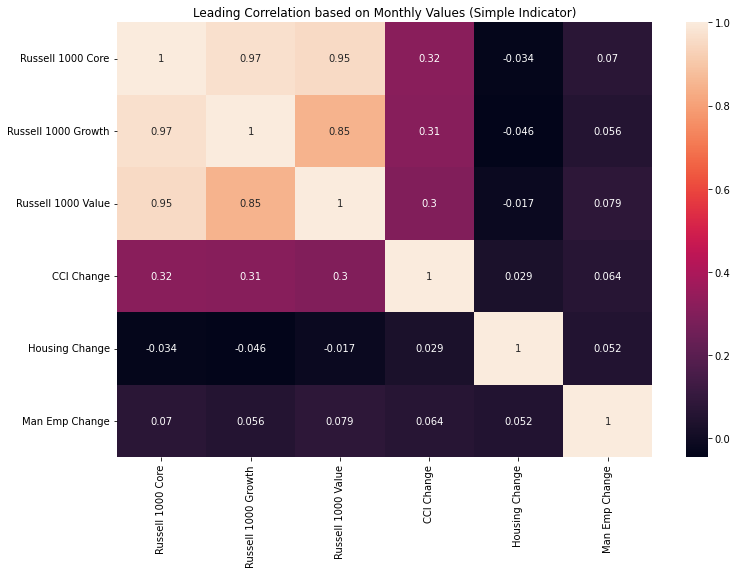

In [92]:
# Plts heatmap showing leading data correlation. 

market_data_corr = simple_leading_monthly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True).set_title('Leading Correlation based on Monthly Values (Simple Indicator)')
plt.show()

## Quarterly - Leading

In [93]:
# Creates Quarterly Leading MD table

quarterly_leading_join = leading_merge[['CCI Change','Housing Change','Man Emp Change']].reset_index().drop(columns = 'Month').groupby(['YEAR','Quarter']).sum().reset_index()
quarterly_strat_join = market_merge_df_compound.reset_index().drop(columns = ['Month','Fed Rate Change (Pct)','Unemployment Change (Pct)', 'Inflation Change (Pct)']).set_index(['YEAR','Quarter']).groupby(['YEAR','Quarter']).agg({'date':'max','Russell 1000 Core':'prod','Russell 1000 Growth':'prod','Russell 1000 Value':'prod'}).reset_index().set_index(['YEAR','Quarter','date']).apply(percentreverse).reset_index()
simple_leading_quarterly_md = pd.merge(quarterly_strat_join,quarterly_leading_join, how = 'left', on = ['YEAR','Quarter']).drop(columns = ['YEAR','Quarter']).set_index('date')

simple_leading_quarterly_md


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            CCI Change  Housing Change  Man Emp Change  
date                                                    
1979-03-31    -0.43882             3.2            62.0  
1979-06-30    -0.51882             2.2            81.0  
1979-09-30     0.00205             1.6          -141.0  
1979-12-31     0.11625            -7.0          -108.0  
1980-03-31    -1.27549             2.2          -309.0  
...                ...             ...             ...  
2014-12-31     1.10440            -1.2            33.0  
2015-03-31    -0.16280             1.2            26.0  
2015-06-30    -0.19790            -0.7            31.0  
2015-09-30    -0.36180             0.2            13.0  
2015-12-31     0.24780             0.1            21.0  

[148 rows x 6 columns]

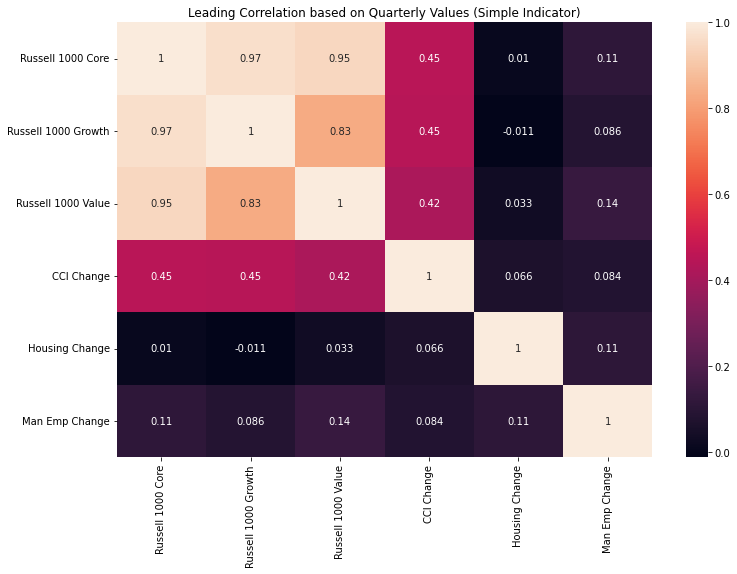

In [94]:
# Plts heatmap showing quarterly leading data correlation. 

market_data_corr = simple_leading_quarterly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True).set_title('Leading Correlation based on Quarterly Values (Simple Indicator)')
plt.show()

## Yearly - Leading

In [95]:
# Creates Quarterly Leading MD table

yearly_leading_join = leading_merge[['CCI Change','Housing Change','Man Emp Change']].reset_index().drop(columns = ['Month', 'Quarter']).groupby(['YEAR']).sum().reset_index()
yearly_strat_join = market_merge_df_compound.reset_index().drop(columns = ['Month','Quarter','Fed Rate Change (Pct)','Unemployment Change (Pct)', 'Inflation Change (Pct)']).set_index(['YEAR']).groupby(['YEAR']).agg({'date':'max','Russell 1000 Core':'prod','Russell 1000 Growth':'prod','Russell 1000 Value':'prod'}).reset_index().set_index(['YEAR','date']).apply(percentreverse).reset_index()
simple_leading_yearly_md = pd.merge(yearly_strat_join,yearly_leading_join, how = 'left', on = ['YEAR']).drop(columns = ['YEAR']).set_index('date')

simple_leading_yearly_md


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-12-31           0.223300             0.239033            0.205474   
1980-12-31           0.318728             0.395721            0.244132   
1981-12-31          -0.051017            -0.113093            0.012578   
1982-12-31           0.203083             0.204562            0.200381   
1983-12-31           0.221251             0.159838            0.282853   
1984-12-31           0.047526            -0.009525            0.100977   
1985-12-31           0.322638             0.328545            0.315152   
1986-12-31           0.178700             0.153619            0.199798   
1987-12-31           0.029265             0.053055            0.004985   
1988-12-31           0.172556             0.112666            0.231601   
1989-12-31           0.304295             0.359236            0.251902   
1990-12-31          -0.042095            -0.002593           -0.080832   
1991-12-31           0.330378             0.412700            0.245500   
1992-12-31           0.089310             0.049904            0.135849   
1993-12-31           0.101772             0.028722            0.180674   
1994-12-31           0.003890             0.026216           -0.019757   
1995-12-31           0.377670             0.371754            0.383560   
1996-12-31           0.224471             0.231225            0.216417   
1997-12-31           0.328517             0.304890            0.351840   
1998-12-31           0.270234             0.387067            0.156290   
1999-12-31           0.209119             0.331580            0.073477   
2000-12-31          -0.077891            -0.224239            0.070147   
2001-12-31          -0.124496            -0.204233           -0.055896   
2002-12-31          -0.216526            -0.278841           -0.155232   
2003-12-31           0.298908             0.297491            0.300305   
2004-12-31           0.114046             0.063000            0.164937   
2005-12-31           0.062657             0.052631            0.070538   
2006-12-31           0.154609             0.090737            0.222455   
2007-12-31           0.057741             0.118129           -0.001733   
2008-12-31          -0.375966            -0.384372           -0.368483   
2009-12-31           0.284326             0.372088            0.196903   
2010-12-31           0.160970             0.167106            0.155060   
2011-12-31           0.015007             0.026420            0.003905   
2012-12-31           0.164223             0.152578            0.175088   
2013-12-31           0.331112             0.334849            0.325268   
2014-12-31           0.132385             0.130498            0.134525   
2015-12-31           0.009175             0.056673           -0.038273   

            CCI Change  Housing Change  Man Emp Change  
date                                                    
1979-12-31    -0.83934             0.0          -106.0  
1980-12-31     0.55138             1.6          -643.0  
1981-12-31    -0.25660            -4.2          -592.0  
1982-12-31     0.73568             1.9         -1342.0  
1983-12-31     3.21981             1.1           925.0  
1984-12-31    -0.39880            -0.6           379.0  
1985-12-31     0.04250             0.1          -323.0  
1986-12-31    -0.60320            -1.6          -221.0  
1987-12-31    -0.07730            -1.8           325.0  
1988-12-31     0.74530             1.0           267.0  
1989-12-31    -0.49900            -0.6          -260.0  
1990-12-31    -2.94220            -1.8          -467.0  
1991-12-31    -0.02600            -0.1          -491.0  
1992-12-31     2.64270            -0.4           -48.0  
1993-12-31     0.35680            -0.3            64.0  
1994-12-31     0.49520             0.8           407.0  
1995-12-31    -0.74800            -1.0           -54.0  
1996-12-31     1.08460             0.9    

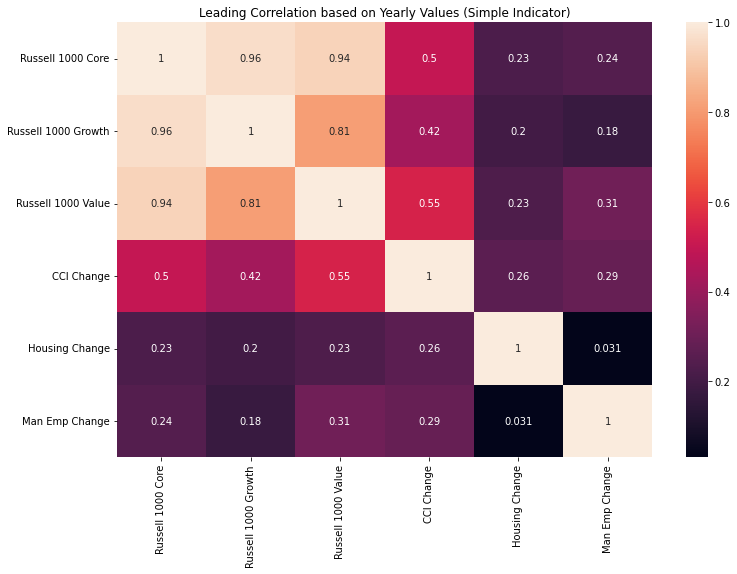

In [96]:
# Plts heatmap showing yearly leading data correlation. 

market_data_corr = simple_leading_yearly_md.reset_index().drop(columns = ['date']).corr()
correlation = market_data_corr
sn.heatmap(correlation, annot=True).set_title('Leading Correlation based on Yearly Values (Simple Indicator)')
plt.show()

# Factor Pick #2 (Leading)

In [97]:
#Creates base model table from quarterly leading MD table
indicator_leading = simple_leading_quarterly_md.copy()

In [98]:
# Assigns values to "Flags" used to determine which portfolio to use. 
# 1 = Value Weighted
# - 1 = Growth Weighted
# 0 = uncertain

indicator_leading.loc[(indicator_leading['CCI Change']<0),'CCI Flag'] = 1
indicator_leading.loc[(indicator_leading['CCI Change']>0),'CCI Flag'] = -1
indicator_leading.loc[(indicator_leading['CCI Change']==0),'CCI Flag'] = 0
indicator_leading.loc[(indicator_leading['Housing Change']<0),'Housing Flag'] = -1
indicator_leading.loc[(indicator_leading['Housing Change']>0),'Housing Flag'] = 2 #Adding additional weight for high correlation
indicator_leading.loc[(indicator_leading['Housing Change']==0),'Housing Flag'] = 0
indicator_leading.loc[(indicator_leading['Man Emp Change']<0),'Man Emp Flag'] = -1
indicator_leading.loc[(indicator_leading['Man Emp Change']>0),'Man Emp Flag'] = 2
indicator_leading.loc[(indicator_leading['Man Emp Change']==0),'Man Emp Flag'] = 0


In [99]:
#Sums Flags to create a prediction
#Positive numbers and 0s will use the Value weighted portfolio.
#Negative numbers will use growth weighted. 

indicator_leading['Flag_Sum'] = indicator_leading['CCI Flag'] + indicator_leading['Housing Flag'] + indicator_leading['Man Emp Flag']
indicator_leading


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            CCI Change  Housing Change  Man Emp Change  CCI Flag  \
date                                                               
1979-03-31    -0.43882             3.2            62.0       1.0   
1979-06-30    -0.51882             2.2            81.0       1.0   
1979-09-30     0.00205             1.6          -141.0      -1.0   
1979-12-31     0.11625            -7.0          -108.0      -1.0   
1980-03-31    -1.27549             2.2          -309.0       1.0   
...                ...             ...             ...       ...   
2014-12-31     1.10440            -1.2            33.0      -1.0   
2015-03-31    -0.16280             1.2            26.0       1.0   
2015-06-30    -0.19790            -0.7            31.0       1.0   
2015-09-30    -0.36180             0.2            13.0       1.0   
2015-12-31     0.24780             0.1            21.0      -1.0   

            Housing Flag  Man Emp Flag  Flag_Sum  
date                                              
1979-03-31           2.0           2.0       5.0  
1979-06-30           2.0           2.0       5.0  
1979-09-30           2.0          -1.0       0.0  
1979-12-31          -1.0          -1.0      -3.0  
1980-03-31           2.0          -1.0       2.0  
...                  ...           ...       ...  
2014-12-31          -1.0           2.0       0.0  
2015-03-31           2.0           2.0       5.0  
2015-06-30          -1.0           2.0       2.0  
2015-09-30           2.0           2.0       5.0  
2015-12-31           2.0           2.0       3.0  

[148 rows x 10 columns]

In [100]:
# Assigns favored portfolios based on pick column.

indicator_leading.loc[(indicator_leading['Flag_Sum'].shift() >0),'Favored'] = 'Russell 1000 Value'
indicator_leading.loc[(indicator_leading['Flag_Sum'].shift() ==0),'Favored'] = 'Russell 1000 Value'
indicator_leading.loc[(indicator_leading['Flag_Sum'].shift() <0),'Favored'] = 'Russell 1000 Growth'
indicator_leading = indicator_leading.replace(np.nan, 'Russell 1000 Value')
indicator_leading

Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            CCI Change  Housing Change  Man Emp Change  CCI Flag  \
date                                                               
1979-03-31    -0.43882             3.2            62.0       1.0   
1979-06-30    -0.51882             2.2            81.0       1.0   
1979-09-30     0.00205             1.6          -141.0      -1.0   
1979-12-31     0.11625            -7.0          -108.0      -1.0   
1980-03-31    -1.27549             2.2          -309.0       1.0   
...                ...             ...             ...       ...   
2014-12-31     1.10440            -1.2            33.0      -1.0   
2015-03-31    -0.16280             1.2            26.0       1.0   
2015-06-30    -0.19790            -0.7            31.0       1.0   
2015-09-30    -0.36180             0.2            13.0       1.0   
2015-12-31     0.24780             0.1            21.0      -1.0   

            Housing Flag  Man Emp Flag  Flag_Sum              Favored  
date                                                                   
1979-03-31           2.0           2.0       5.0   Russell 1000 Value  
1979-06-30           2.0           2.0       5.0   Russell 1000 Value  
1979-09-30           2.0          -1.0       0.0   Russell 1000 Value  
1979-12-31          -1.0          -1.0      -3.0   Russell 1000 Value  
1980-03-31           2.0          -1.0       2.0  Russell 1000 Growth  
...                  ...           ...       ...                  ...  
2014-12-31          -1.0           2.0       0.0   Russell 1000 Value  
2015-03-31           2.0           2.0       5.0   Russell 1000 Value  
2015-06-30          -1.0           2.0       2.0   Russell 1000 Value  
2015-09-30           2.0           2.0       5.0   Russell 1000 Value  
2015-12-31           2.0           2.0       3.0   Russell 1000 Value  

[148 rows x 11 columns]

In [101]:
# Checks to see which portfolio was held last quarter and determines if a Trade is necessary. 

indicator_leading.loc[indicator_leading['Favored'] != indicator_leading['Favored'].shift(), "Trade/Hold"] = "Trade"
indicator_leading = indicator_leading.replace(np.nan, 'X')
indicator_leading


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            CCI Change  Housing Change  Man Emp Change  CCI Flag  \
date                                                               
1979-03-31    -0.43882             3.2            62.0       1.0   
1979-06-30    -0.51882             2.2            81.0       1.0   
1979-09-30     0.00205             1.6          -141.0      -1.0   
1979-12-31     0.11625            -7.0          -108.0      -1.0   
1980-03-31    -1.27549             2.2          -309.0       1.0   
...                ...             ...             ...       ...   
2014-12-31     1.10440            -1.2            33.0      -1.0   
2015-03-31    -0.16280             1.2            26.0       1.0   
2015-06-30    -0.19790            -0.7            31.0       1.0   
2015-09-30    -0.36180             0.2            13.0       1.0   
2015-12-31     0.24780             0.1            21.0      -1.0   

            Housing Flag  Man Emp Flag  Flag_Sum              Favored  \
date                                                                    
1979-03-31           2.0           2.0       5.0   Russell 1000 Value   
1979-06-30           2.0           2.0       5.0   Russell 1000 Value   
1979-09-30           2.0          -1.0       0.0   Russell 1000 Value   
1979-12-31          -1.0          -1.0      -3.0   Russell 1000 Value   
1980-03-31           2.0          -1.0       2.0  Russell 1000 Growth   
...                  ...           ...       ...                  ...   
2014-12-31          -1.0           2.0       0.0   Russell 1000 Value   
2015-03-31           2.0           2.0       5.0   Russell 1000 Value   
2015-06-30          -1.0           2.0       2.0   Russell 1000 Value   
2015-09-30           2.0           2.0       5.0   Russell 1000 Value   
2015-12-31           2.0           2.0       3.0   Russell 1000 Value   

           Trade/Hold  
date                   
1979-03-31      Trade  
1979-06-30          X  
1979-09-30          X  
1979-12-31          X  
1980-03-31      Trade  
...               ...  
2014-12-31          X  
2015-03-31          X  
2015-06-30          X  
2015-09-30          X  
2015-12-31          X  

[148 rows x 12 columns]

In [102]:
# Assigns Portfolio weights to model
indicator_leading['Value Weighted Return'] = indicator_leading['Russell 1000 Core'] * .02 + indicator_leading['Russell 1000 Value'] * .97 + indicator_leading['Russell 1000 Growth'] * .01
indicator_leading['Growth Weighted Return'] = indicator_leading['Russell 1000 Core'] * .1 + indicator_leading['Russell 1000 Growth'] * .2 + indicator_leading['Russell 1000 Value'] * .7
indicator_leading['Core Weighted Return'] = indicator_leading['Russell 1000 Core'] * .2 + indicator_leading['Russell 1000 Value'] * .8 + indicator_leading['Russell 1000 Growth'] * .0

# Creates rows with performance of all 3 strategies
indicator_leading.loc[indicator_leading['Favored'] == 'Russell 1000 Core', "Selection Return"] =  indicator_leading['Value Weighted Return']
indicator_leading.loc[indicator_leading['Favored'] == 'Russell 1000 Growth', "Selection Return"] =  indicator_leading['Growth Weighted Return']
indicator_leading.loc[indicator_leading['Favored'] == 'Russell 1000 Value', "Selection Return"] =  indicator_leading['Value Weighted Return']

indicator_leading['Favored'] = indicator_leading['Favored'].apply(portswitch)

indicator_leading


Russell 1000 Core  Russell 1000 Growth  Russell 1000 Value  \
date                                                                     
1979-03-31           0.079500             0.064693            0.094028   
1979-06-30           0.037425             0.028440            0.046438   
1979-09-30           0.080900             0.082252            0.079606   
1979-12-31           0.010574             0.045566           -0.024672   
1980-03-31          -0.056568            -0.052713           -0.060193   
...                       ...                  ...                 ...   
2014-12-31           0.048811             0.047843            0.049801   
2015-03-31           0.015916             0.038376           -0.007219   
2015-06-30           0.001134             0.001200            0.001084   
2015-09-30          -0.068293            -0.052901           -0.083950   
2015-12-31           0.064969             0.073171            0.056352   

            CCI Change  Housing Change  Man Emp Change  CCI Flag  \
date                                                               
1979-03-31    -0.43882             3.2            62.0       1.0   
1979-06-30    -0.51882             2.2            81.0       1.0   
1979-09-30     0.00205             1.6          -141.0      -1.0   
1979-12-31     0.11625            -7.0          -108.0      -1.0   
1980-03-31    -1.27549             2.2          -309.0       1.0   
...                ...             ...             ...       ...   
2014-12-31     1.10440            -1.2            33.0      -1.0   
2015-03-31    -0.16280             1.2            26.0       1.0   
2015-06-30    -0.19790            -0.7            31.0       1.0   
2015-09-30    -0.36180             0.2            13.0       1.0   
2015-12-31     0.24780             0.1            21.0      -1.0   

            Housing Flag  Man Emp Flag  Flag_Sum          Favored Trade/Hold  \
date                                                                           
1979-03-31           2.0           2.0       5.0   Value Weighted      Trade   
1979-06-30           2.0           2.0       5.0   Value Weighted          X   
1979-09-30           2.0          -1.0       0.0   Value Weighted          X   
1979-12-31          -1.0          -1.0      -3.0   Value Weighted          X   
1980-03-31           2.0          -1.0       2.0  Growth Weighted      Trade   
...                  ...           ...       ...              ...        ...   
2014-12-31          -1.0           2.0       0.0   Value Weighted          X   
2015-03-31           2.0           2.0       5.0   Value Weighted          X   
2015-06-30          -1.0           2.0       2.0   Value Weighted          X   
2015-09-30           2.0           2.0       5.0   Value Weighted          X   
2015-12-31           2.0           2.0       3.0   Value Weighted          X   

            Value Weighted Return  Growth Weighted Return  \
date                                                        
1979-03-31               0.093445                0.086708   
1979-06-30               0.046078                0.041937   
1979-09-30               0.079658                0.080264   
1979-12-31              -0.023265               -0.007100   
1980-03-31              -0.060046               -0.058334   
...                           ...                     ...   
2014-12-31               0.049762                0.049311   
2015-03-31              -0.006301                0.004213   
2015-06-30               0.001086                0.001112   
2015-09-30              -0.083326               -0.076174   
2015-12-31               0.056693                0.060578   

            Core Weighted Return  Selection Return  
date                                                
1979-03-31              0.091123          0.093445  
1979-06-30              0.044635          0.046078  
1979-09-30              0.079865          0.079658  
1979-12-31             -0.017623         -0.023265  
1980-03-31 

In [103]:
#Generates results table and calculates value of $100

indicator_leading_results = indicator_leading[['Russell 1000 Core','Selection Return']].copy()
indicator_leading_results.loc[indicator_leading_results.index[0], 'Core Portfolio Value'] = 100
indicator_leading_results.loc[indicator_leading_results.index[0], 'Selection Portfolio Value'] = 100
indicator_leading_results.loc[datetime.datetime.strptime('1978-12-31', '%Y-%m-%d').date()] = [0,0, 100,100]  # adding a row
indicator_leading_results = indicator_leading_results.sort_index()
for i in range(indicator_leading_results.index.size - 1):
    indicator_leading_results['Core Portfolio Value'].iloc[i+1] = (indicator_leading_results['Russell 1000 Core'].apply(percentagecompound).iloc[i+1] * indicator_leading_results['Core Portfolio Value'].iloc[i])
    indicator_leading_results['Selection Portfolio Value'].iloc[i+1] = (indicator_leading_results['Selection Return'].apply(percentagecompound).iloc[i+1] * indicator_leading_results['Selection Portfolio Value'].iloc[i])

indicator_leading_results


Russell 1000 Core  Selection Return  Core Portfolio Value  \
date                                                                    
1978-12-31           0.000000          0.000000            100.000000   
1979-03-31           0.079500          0.093445            107.950000   
1979-06-30           0.037425          0.046078            111.990000   
1979-09-30           0.080900          0.079658            121.050000   
1979-12-31           0.010574         -0.023265            122.330000   
...                       ...               ...                   ...   
2014-12-31           0.048811          0.049762           6015.980856   
2015-03-31           0.015916         -0.006301           6111.730693   
2015-06-30           0.001134          0.001086           6118.662755   
2015-09-30          -0.068293         -0.083326           5700.800601   
2015-12-31           0.064969          0.056693           6071.176340   

            Selection Portfolio Value  
date                                   
1978-12-31                 100.000000  
1979-03-31                 109.344454  
1979-06-30                 114.382783  
1979-09-30                 123.494299  
1979-12-31                 120.621207  
...                               ...  
2014-12-31                7184.568151  
2015-03-31                7139.300917  
2015-06-30                7147.052522  
2015-09-30                6551.516711  
2015-12-31                6922.940271  

[149 rows x 4 columns]

In [104]:
indicator_leading_Ret = ((indicator_leading[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].apply(percentagecompound).prod() ** (1/time_period) - 1)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Return'})
indicator_leading_Std = (indicator_leading[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].std().apply(annualfromquarterlystd)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Std'})
indicator_leading_Stats = pd.merge(indicator_leading_Ret, indicator_leading_Std, on='Strategy', how = 'left')
indicator_leading_Stats['Sharpe'] = ((indicator_leading_Stats['Annualized Return'] - 2) / indicator_leading_Stats['Annualized Std']).round(2)
indicator_leading_Stats = indicator_leading_Stats.set_index('Strategy')
indicator_leading_Stats


Annualized Return  Annualized Std  Sharpe
Strategy                                                      
Russell 1000 Core            11.736886       16.350467    0.60
Russell 1000 Growth          11.047046       18.648083    0.49
Russell 1000 Value           12.048407       15.510075    0.65
Selection Return             12.134069       15.722065    0.64

In [105]:
#Calculates Annualized Return

((indicator_leading[['Russell 1000 Core','Russell 1000 Growth','Russell 1000 Value','Selection Return']].apply(percentagecompound).prod() ** (1/time_period) - 1)*100).reset_index().rename(columns = {'index': 'Strategy',0:'Annualized Return'})


Strategy  Annualized Return
0    Russell 1000 Core          11.736886
1  Russell 1000 Growth          11.047046
2   Russell 1000 Value          12.048407
3     Selection Return          12.134069

In [106]:
#Calculates number of trades over period

indicator_leading_trades = indicator_leading[['Russell 1000 Core','Trade/Hold']].groupby('Trade/Hold').count().rename(columns = {'Russell 1000 Core':'Total'})
indicator_leading_trades['Average Yearly Trades'] = indicator_leading_trades['Total'] / time_period
indicator_leading_trades['Average Yearly Trades'] = indicator_leading_trades['Average Yearly Trades'].round(1)
indicator_leading_trades = indicator_leading_trades.drop('X')
indicator_leading_trades


Total  Average Yearly Trades
Trade/Hold                              
Trade          55                    1.5

In [107]:
#Plots selected portfolio vs Russell 1000 Core over period. 

fig = px.line(indicator_leading_results.reset_index(), x = 'date', y=['Core Portfolio Value','Selection Portfolio Value'], title='Core vs Indicator Selection v2')
fig.show()

In [108]:
# Value of $100 DF

indicator_leading_results[['Core Portfolio Value','Selection Portfolio Value']].iloc[-1].round(2).reset_index().rename(columns = {'index':'Portfolio', 0:'Ending Port Val'}).set_index('Portfolio').style.set_caption('Value of $100')


In [109]:
# Trade Schedule 

indicator_leading_trade_pivot = indicator_leading[['Trade/Hold','Favored']].reset_index()
indicator_leading_trade_pivot.loc[indicator_leading_trade_pivot['Trade/Hold'] == 'Trade', 'Trade/Hold' ] = indicator_leading_trade_pivot['Trade/Hold'] + " - " + indicator_leading_trade_pivot['Favored']#momentum_2_trade_pivot = momentum_2_trade_pivot.drop(columns = 'Pick')
indicator_leading_trade_pivot = indicator_leading_trade_pivot.drop(columns = 'Favored')
indicator_leading_trade_pivot['Month'] = indicator_leading_trade_pivot['date'].astype(str).str.split('-').str[1]
indicator_leading_trade_pivot['Year'] = indicator_leading_trade_pivot['date'].astype(str).str.split('-').str[0]
indicator_leading_trade_pivot = indicator_leading_trade_pivot.drop(columns = 'date').pivot(index = 'Year', columns = 'Month').rename(columns = {'03': 'Qtr 1','06': 'Qtr 2','09': 'Qtr 3','12': 'Qtr 4'}).style.apply(lambda x: ["background: green" if 'Trade' in value else "" for value in x], axis = 1)
indicator_leading_trade_pivot
